In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
import seaborn as sns
import scipy
from xgcm import Grid
import matplotlib.animation as animation
from IPython.display import HTML
import cmocean
from scipy.fft import fft, fftfreq
plt.rcParams.update({'font.size': 10})
from scipy import signal
import sys
import h5py
sys.path.append('./tools/')
##m6toolbox is a python package that has a function that helps visualize vertical sections
import m6toolbox
import m6plot
import cmasher as cmr
 # mpl.rcParams['animation.embed_limit'] = 2**128
print('all done')
%matplotlib inline
nanmasked = plt.get_cmap('turbo').copy()
nanmasked.set_bad('black')
nanmasked2 = plt.get_cmap('RdBu').copy()
nanmasked2.set_bad('black')

Basemap module not found. Some regional plots may not function properly
all done


In [2]:
from dask.distributed import Client
import dask
import os
client = Client()
client

<Client: 'tcp://127.0.0.1:45485' processes=1 threads=1, memory=7.81 GiB>

### Loading z* coordinate data + static grid data

In [3]:
### loading in year 1994 budgets (native grid)

ds = xr.open_mfdataset('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/control/1997/*budgets_1997_01.nc',engine='h5netcdf',chunks='auto',combine='nested',concat_dim='time',decode_timedelta='CFTimedeltaCoder')
# ds = ds.isel(time=slice(0,11))
dsnot = xr.open_mfdataset('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/*budgets*.nc',chunks='auto',engine='h5netcdf',combine='nested',concat_dim='time',decode_timedelta='CFTimedeltaCoder')
print('data loaded!')

# # ## full static on the native full grid cropped to region
data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/19970101.ocean_static.nc'
static = xr.open_dataset(data_path,chunks='auto')#chunks={'xq':300,'yq':100,'xh':300,'yh':100})
static = static.isel(xh=slice(0,601),yh=slice(0,343),xq=slice(0,601),yq=slice(0,343))

data loaded!


In [9]:
data_path ='/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/ANALYSIS/tend2.nc'
tend2 = xr.open_dataset(data_path,chunks='auto').isel(time=slice(1,None))
# del hadvw
# bio2 = bio2.sel(time=slice('1997-01-01','1997-02-01'))
# diff2 = diff.rename({'__xarray_dataarray_variable__':'diff2'})

If we are in native coordinates, then we can create a mask for all land areas with depth. 

In [4]:
### defining xgcm grid for best practices 

ds['dxt'] = static['dxt'].fillna(0.)
ds['dyt'] = static['dyt'].fillna(0.)
ds['areacello'] = static['areacello'].fillna(0.)
ds['depth_ocean'] = static['depth_ocean']#.fillna(0.)
ds['wet'] = static['wet']
# static['dxt'] = static['dxt'].fillna(0.)
# static['dyt'] = static['dyt'].fillna(0.)
# static['areacello'] = static['areacello'].fillna(0.)

metrics = {
    ('X',): ['dxt'], # X distances
    ('Y',): ['dyt'], # Y distances
    ('X', 'Y'): ['areacello'] # Areas
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'zl', 'left':'zi'},
       'time': {'center':'time'}}

# ds = xr.merge([ds,static]) # we have to merge so that the time dimension will be processed correctly

grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])#not periodic because it's a regional model, periodic=['X'])

Create boundary mask and topography mask.

In [67]:
### create mask for topography if in native z coordinates

mask = np.tile(ds.zl,[601,343,1]) # zgrid tiled for each grid point
mask = mask.T 

mask2 = np.tile(static.depth_ocean,[75,1,1]) # seafloor depth tiled for each z level

mask3 = mask<mask2

static['wet_depth'] = xr.DataArray(data=mask3.astype('int'),
                         coords={'zl': ds['zl'],'yh': ds['yh'],'xh': ds['xh']},
                         dims=('zl','yh','xh'))

del mask, mask2, mask3
# static['wet_depth_xq'] = xr.DataArray(data=mask3.astype('int'),
#                          coords={'zl': ds['zl'],'yh': ds['yh'],'xq': ds['xq']},
#                          dims=('zl','yh','xq'))

# static['wet_depth_yq'] = xr.DataArray(data=mask3.astype('int'),
#                          coords={'zl': ds['zl'],'yq': ds['yq'],'xh': ds['xh']},
#                          dims=('zl','yq','xh'))

# mask = np.tile(ds.zi,[601,343,1]) # zgrid tiled for each grid point
# mask = mask.T 

# mask2 = np.tile(static.depth_ocean,[76,1,1]) # seafloor depth tiled for each z level

# mask3 = mask<mask2

# static['wet_depth_zi'] = xr.DataArray(data=mask3.astype('int'),
#                          coords={'zi': ds['zi'],'yh': ds['yh'],'xh': ds['xh']},
#                          dims=('zi','yh','xh'))

# og = static.wet_depth.where(static.wet_depth)
# og_su = og.shift(zl=1) # shift down
# og_su[0,:,:] = og[0,:,:] # so that surface doesn't get nanned out
# og_sd = og.shift(zl=-1) # shift up
# all_og = [og, og_su, og_sd]
# boundary_masks = []
# for og in all_og:
#     og_sr = og.shift(xh=1) # shift right
#     og_srn = og_sr.shift(yh=1) # shift right and north
#     og_srs = og_sr.shift(yh=-1) # shift right and south
#     og_sl = og.shift(xh=-1) # shift left
#     og_sln = og_sl.shift(yh=1) # shift left and north
#     og_sls = og_sl.shift(yh=-1) # shift left and south
#     og_sn = og.shift(yh=1) # shift north
#     og_ss = og.shift(yh=-1) # shift south
#     boundary_mask = og_sr + og_sl + og_sn + og_ss + og_srn + og_srs + og_sln + og_sls
#     boundary_masks.append(boundary_mask)
    
# boundary_mask = boundary_masks[0] + boundary_masks[1] + boundary_masks[2]
# boundary_mask = boundary_mask + og_su + og_sd
# boundary_mask[:,:,-1]=26 # so that the open ocean isn't counted
# boundary_mask[:,-1,:]=26 # so that the open ocean isn't counted
# boundary_mask[:,0,:]=26 # so that the open ocean isn't counted
# boundary_mask = boundary_mask.where(static.wet_depth,26)-26 # taking out the land so nan is just boundary,water is 0
# boundary_mask = boundary_mask.where(np.isnan(boundary_mask)==0,1) # 1 for boundary, 0 for everywhere else
# static['boundary_mask'] = xr.DataArray(data=boundary_mask.astype('int'),
#                          coords={'zl': ds['zl'],'yh': ds['yh'],'xh': ds['xh']},
#                          dims=('zl','yh','xh'))

# del og, og_su, og_sd, all_og, og_sr, og_srn, og_srs, og_sl, og_sln, og_sls, og_sn, og_ss, boundary_mask, boundary_masks

For z-coordinates:

In [31]:
### defining xgcm grid for best practices 

# static['z_l'] = ds['z_l']
# static['z_i'] = ds['z_i']
# static['dzt'] = xr.DataArray(data=ds['z_i'].diff('z_i').values, coords={'z_l': ds['z_l']}, dims=('z_l'))
static['dxt'] = static['dxt'].fillna(0.)
static['dyt'] = static['dyt'].fillna(0.)
static['areacello'] = static['areacello'].fillna(0.)
# static['volcello'] = ds['volcello'].fillna(0.)

metrics = {
    ('X',): ['dxt'], # X distances
    ('Y',): ['dyt'], # Y distances
    # ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    # ('X', 'Y', 'Z'): ['volcello'], # Volumes
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'}}#,
        # 'Z': {'center': 'z_l', 'outer': 'z_i'}}

grid = Grid(static, coords=coords, metrics=metrics, periodic=[])#not periodic because it's a regional model, periodic=['X'])

static['wet_depth'] = xr.DataArray(data=(np.isnan(ds.temp.isel(time=0))==0).astype('int'),
                         coords={'z_l': ds['z_l'],'yh': ds['yh'],'xh': ds['xh']},
                         dims=('z_l','yh','xh'))

og = static.wet_depth.where(static.wet_depth)
og_su = og.shift(z_l=1) # shift down
og_su[0,:,:] = og[0,:,:] # so that surface doesn't get nanned out
og_sd = og.shift(z_l=-1) # shift up
all_og = [og, og_su, og_sd]
boundary_masks = []
for og in all_og:
    og_sr = og.shift(xh=1) # shift right
    og_srn = og_sr.shift(yh=1) # shift right and north
    og_srs = og_sr.shift(yh=-1) # shift right and south
    og_sl = og.shift(xh=-1) # shift left
    og_sln = og_sl.shift(yh=1) # shift left and north
    og_sls = og_sl.shift(yh=-1) # shift left and south
    og_sn = og.shift(yh=1) # shift north
    og_ss = og.shift(yh=-1) # shift south
    boundary_mask = og_sr + og_sl + og_sn + og_ss + og_srn + og_srs + og_sln + og_sls
    boundary_masks.append(boundary_mask)

boundary_mask = boundary_masks[0] + boundary_masks[1] + boundary_masks[2]
boundary_mask = boundary_mask + og_su + og_sd
boundary_mask[:,:,-1]=26 # so that the open ocean isn't counted
boundary_mask[:,-1,:]=26 # so that the open ocean isn't counted
boundary_mask[:,0,:]=26 # so that the open ocean isn't counted
boundary_mask = boundary_mask.where(static.wet_depth,26)-26 # taking out the land so nan is just boundary,water is 0
boundary_mask = boundary_mask.where(np.isnan(boundary_mask)==0,1) # 1 for boundary, 0 for everywhere else
static['boundary_mask'] = xr.DataArray(data=boundary_mask.astype('int'),
                         coords={'z_l': ds['z_l'],'yh': ds['yh'],'xh': ds['xh']},
                         dims=('z_l','yh','xh'))

del og, og_su, og_sd, all_og, og_sr, og_srn, og_srs, og_sl, og_sln, og_sls, og_sn, og_ss, boundary_mask, boundary_masks

### Helper functions

In [19]:
### average between the layers for pcolormesh
z = ds.e.rolling(zi=2).mean()
z = z[:,1:,:,:] # rolling mean shifts right, so we can shift one
z = z.swap_dims({"zi": "zl"}) # change dimensions
z = z.where(np.isnan(z)==0,-1)
# x = ds.xh + 0*z # tile using the broadcasting function
# y = ds.yh + 0*z # tile using the broadcasting function
ds['z'] = z
# ds['x'] = x
# ds['y'] = y
ds = ds.assign_coords(x=ds.x,y=ds.y,z=ds.z)

In [5]:
xq = np.concatenate(([2*ds.xq[0]-ds.xq[1]],ds.xq)) # extend the longitude coordinate since pcolormesh plots from corner
yq = np.concatenate(([2*ds.yq[0]-ds.yq[1]],ds.yq)) # extend the longitude coordinate since pcolormesh plots from corner

def plotxz(y,record,variable,vmin=None,vmax=None,depth=7000,plotgrid=False,mumol=False):
    # y is the desired latitude, ex: 23.5
    # record is the desired time in index, ex: 0 for Jan 1 or 'mean' for time mean
    # variable is the thing to plot, i.e., ds.o2 or ds.jo2/1035
    # depth is the depth you want up to, i.e. 700
    # plotgrid is if you want the native grid overlaid
    # mumol is if you want to change units from mol to mumol (multiplies variables by 1e6)
    # example usage: plotyz(23.5,0,'o2',1e-4,2.5e-4)
    z_max = np.abs(ds.zi- depth).argmin().values
    if record=='mean':
        x,z,q = m6toolbox.section2quadmesh(xq, ds.e.isel(zi=slice(0,z_max)).sel(yh=y,method='nearest').mean('time').values, (variable).isel(zl=slice(0,z_max-1)).sel(yh=y,method='nearest').mean('time').values, representation='pcm')
    else:
        x,z,q = m6toolbox.section2quadmesh(xq, ds.e.isel(zi=slice(0,z_max)).sel(yh=y,method='nearest').isel(time=record).values, (variable).isel(zl=slice(0,z_max-1)).sel(yh=y,method='nearest').isel(time=record).values, representation='pcm')
    z[np.isnan(z)]=0 # land areas cannot be nan for plotting 
    if mumol: q=1e6*q 
    fig, ax = plt.subplots(1, 1, figsize=(18,4),dpi=200)
    ax.set_facecolor('black')
    plt.pcolormesh(x, z, q,cmap=nanmasked,vmin=vmin,vmax=vmax);
    # if mumol:
        # plt.colorbar(label=(variable).attrs['long_name'] + '\n [$\mu$' + (variable).attrs['units'] + ']' ,pad=0.01)
    # else:
        # plt.colorbar(label=(variable).attrs['long_name'] + '\n [' + (variable).attrs['units'] + ']' ,pad=0.01)
    plt.colorbar()
    if plotgrid: plt.plot(x, z.T, 'k',linewidth=0.5);
    plt.xlabel('longitude [$^o$E]');
    plt.ylabel('depth [m]')

def plotyz(x,record,variable,vmin=None,vmax=None,depth=7000,plotgrid=False,mumol=False):
    # x is the desired longitude, ex: -80
    # record is the desired time in index, ex: 0 for Jan 1
    # variable is the name, ex: 'o2'
    # plotgrid is if you want the native grid overlaid
    # mumol is if you want to change units from mol to mumol (multiplies variables by 1e6)
    # example usage: plotyz(23.5,0,'o2',1e-4,2.5e-4)
    z_max = np.abs(ds.zi- depth).argmin().values
    if record=='mean':
        y,z,q = m6toolbox.section2quadmesh(yq, ds.e.isel(zi=slice(0,z_max)).sel(xh=x,method='nearest').mean('time').values, (variable).isel(zl=slice(0,z_max-1)).sel(xh=x,method='nearest').mean('time').values, representation='pcm')
    else:
        y,z,q = m6toolbox.section2quadmesh(yq, ds.e.isel(zi=slice(0,z_max)).sel(xh=x,method='nearest').isel(time=record).values, (variable).isel(zl=slice(0,z_max-1)).sel(xh=x,method='nearest').isel(time=record).values, representation='pcm')
    z[np.isnan(z)]=0 # land areas cannot be nan for plotting 
    if mumol: q=1e6*q # converts mol/kg to mumol/kg
    fig, ax = plt.subplots(1, 1, figsize=(18,4),dpi=200)
    ax.set_facecolor('black')
    plt.pcolormesh(y, z, q,cmap=nanmasked,vmin=vmin,vmax=vmax);
    plt.colorbar()
    # if mumol:
        # plt.colorbar(label=(variable).attrs['long_name'] + '\n [$\mu$' + (variable).attrs['units'] + ']' ,pad=0.01)
    # else:
        # plt.colorbar(label=(variable).attrs['long_name'] + '\n [' + (variable).attrs['units'] + ']' ,pad=0.01)
    if plotgrid: plt.plot(y, z.T, 'k',linewidth=0.5);
    plt.xlabel('latitude [$^o$N]');
    plt.ylabel('depth [m]')

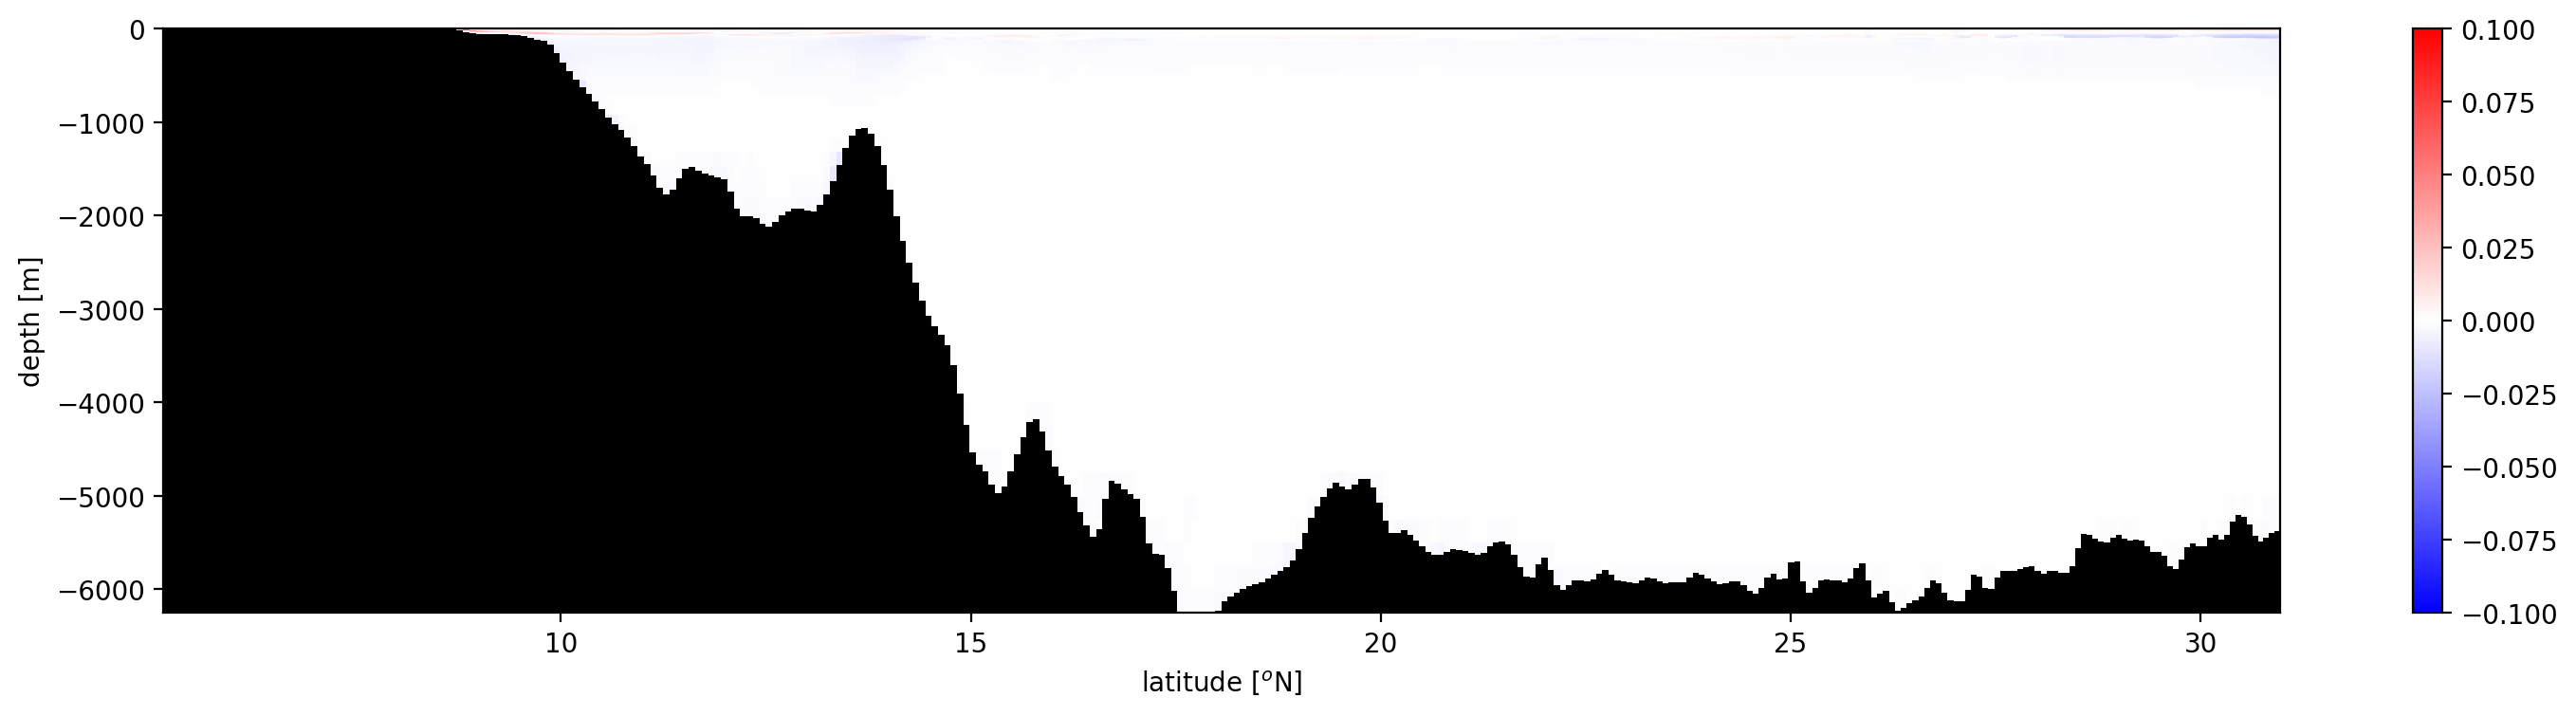

In [8]:
# %%time
nanmasked = plt.get_cmap('bwr').copy()
nanmasked.set_bad('black')

plotyz(-60,20,ds.jo2,depth=7000,plotgrid=False,mumol=True,vmin=-0.10,vmax=0.10) #,vmin=-0.02,vmax=0.02

Text(0.5, 1.0, 'mean o2 flux - tendency (1993-1997)')

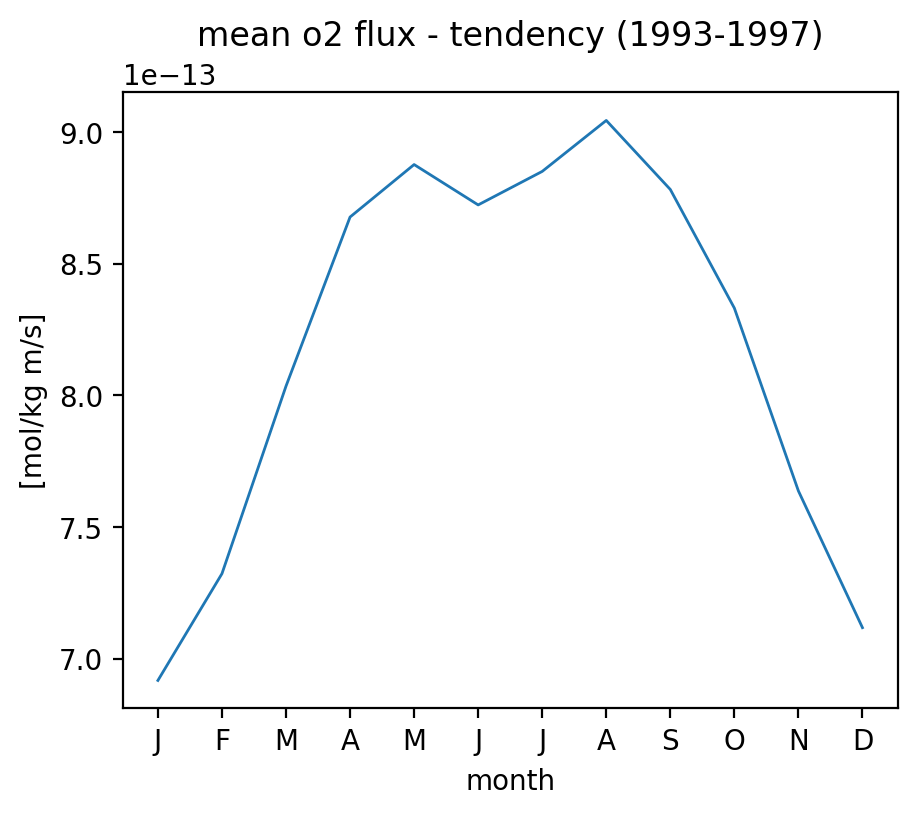

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=200)
# fluxes = hadv2.o2_advection_xy + vadv2.o2h_tendency_vert_remap + diff2.o2_vdiffuse_impl + bio2.jo2
# flux_avg = grid.average(fluxes,['X','Y'])
# flux_avg.isel(time=slice(1,None)).plot(x='time',ax=ax,linewidth=0.75)
# tend_avg = grid.average(tend2.o2h_tendency,['X','Y'])
# tend_avg.isel(time=slice(1,None)).plot(x='time',ax=ax,linewidth=0.75)
# diff = hadv2.o2_advection_xy + vadv2.o2h_tendency_vert_remap + diff2.o2_vdiffuse_impl + bio2.jo2 - tend2.o2h_tendency
# diff_avg = diff.isel(time=slice(1,None)).groupby('time.month').mean()
# diff_avg = grid.average(diff_avg,['X','Y'])
diff_avg.plot(x='month',ax=ax,linewidth=1)
ax.set_xticks(list(range(1,13)))
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
# plt.legend(['fluxes','tendency', 'fluxes - tendency'])
plt.ylabel('[mol/kg m/s]')
# plt.xlim([bio2.time[1],bio2.time[-1]])
# plt.ylim([-3e-11,3e-11])
plt.title('mean o2 flux - tendency (1993-1997)')

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 329.21 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


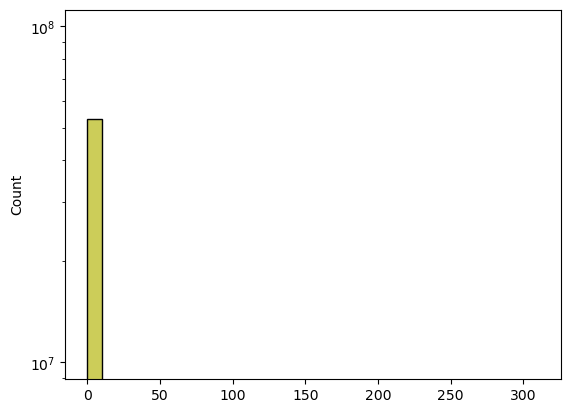

In [23]:
# stacked = divo2h_t.stack(xy=("xh", "yh"))
# stacks = xr.merge([stacked.rename('divo2h_t'),divo2h_not.rename('divo2h_not').stack(xy=("xh", "yh"))])
# stacks
# ax = sns.histplot(data=stacks.isel(time=0).to_dataarray(), bins=30) #grid.average(divo2h_t,['X','Y'])
# ax = sns.histplot(data=btm_o2, bins=range(0,311,10),color='tab:cyan')
test = dsnot.o2.isel(zl=depth_ind).values.ravel()
ax = sns.histplot(data=test, bins=range(0,311,10),color='tab:olive')
ax.set_yscale('log')
# fig, ax = plt.subplots()
# for a in [stacks.divo2h_t, stacks.divo2h_not]:
    # sns.distplot(a, bins=range(1, 110, 10), ax=ax, kde=False)
# ax.set_xlim([0, 100])

### Meridional overturning circulation
For the most accurate estimate of the overturning circulation, we must convert from depth to density coordinates. We start with a pre-determined rho axis borrowed from the MOM6 analysis cookbook, but in general, the values of rho are available for us to choose. To use rho as a coordinate, we need to shift it to the 'v' coordinate (yq instead of yh) so that it can be directly applied. We can then use grid.transform() to relocate the values of the meridional overturning according to values of density at the same points. Finally, we convert units from kg/s to Sv (10$^6$ m$^3$/s). 

(array([1.06000e+02, 1.04000e+02, 1.16000e+02, 1.34000e+02, 1.47000e+02,
        1.61000e+02, 1.75000e+02, 1.75000e+02, 2.00000e+02, 1.94000e+02,
        2.64000e+02, 2.79000e+02, 4.63000e+02, 6.76000e+02, 8.93000e+02,
        1.44500e+03, 1.34900e+03, 1.61100e+03, 2.41100e+03, 2.88700e+03,
        3.58800e+03, 4.93400e+03, 5.27600e+03, 5.31400e+03, 7.20100e+03,
        9.41200e+03, 1.29890e+04, 1.48610e+04, 1.69940e+04, 2.51730e+04,
        2.97330e+04, 3.85790e+04, 6.17050e+04, 7.32530e+04, 7.03630e+04,
        5.84480e+04, 5.47900e+04, 6.06880e+04, 6.38860e+04, 6.96380e+04,
        7.75150e+04, 8.08880e+04, 7.51890e+04, 7.22050e+04, 6.94880e+04,
        7.37540e+04, 7.25780e+04, 7.45470e+04, 7.32300e+04, 7.54450e+04,
        8.27630e+04, 8.97950e+04, 9.25560e+04, 8.95940e+04, 7.69290e+04,
        7.54670e+04, 7.94290e+04, 7.76910e+04, 7.89850e+04, 8.01340e+04,
        7.82850e+04, 7.89950e+04, 8.19500e+04, 8.41010e+04, 9.05490e+04,
        9.72580e+04, 1.00661e+05, 1.25967e+05, 1.58

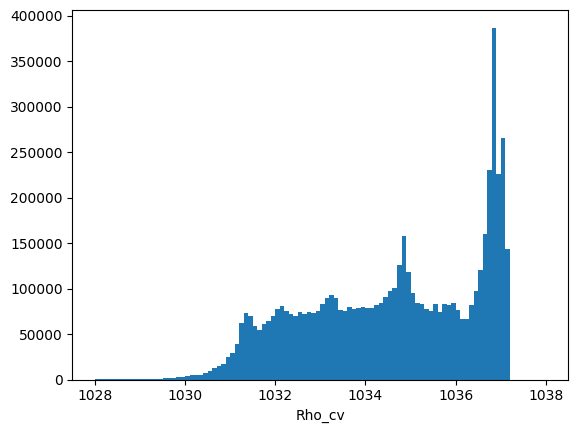

In [7]:
### Remapping vmo to density coordinates

### from MOM6 analysis cookbook
rho2_axis = np.array([1013.750000,1028.500000,1029.242188,1029.718750,1030.179688,1030.625000,1031.054688,1031.468750,1031.867188,1032.250000,1032.617188,1032.968750,1033.304688,1033.625000
,1033.929688,1034.218750,1034.492188,1034.992188,1035.218750,1035.429688,1035.625000,1035.804688,1035.968750,1036.117188,1036.250000,1036.375000,1036.500000,1036.625000,1036.750000,
1036.875000,1037.000000,1037.125000,1037.250000,1037.656250])

### interpolate density values to vmo grid
rho2 = grid.interp(ds.Rho_cv.mean('time'), 'Y', boundary='extend').rename('rho2').chunk({'z_l':-1})
### transform to rho coordinates using rho data on vmo points and rho axis
vmo_rho2 = grid.transform(ds.vmo.mean('time').chunk({'z_l':-1}), target = rho2_axis, target_data=rho2,  method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

### filter out any nan values
vmo_so_offline = vmo_rho2.where(vmo_rho2<1e14)#.sel(rho2=slice(1033,1038))
### MOC calculation, converting to Sv
psi_so_offline = (vmo_so_offline.sum('xh').cumsum('rho2') - vmo_so_offline.sum('xh').sum('rho2'))/1035/1.0e6 + 0.1

To gain more physical intuition for the MOC, we can re-transform our MOC from density coordiantes back into depth coordinates, using thkcello to tell us the mean depth of the isopycnals.

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warn

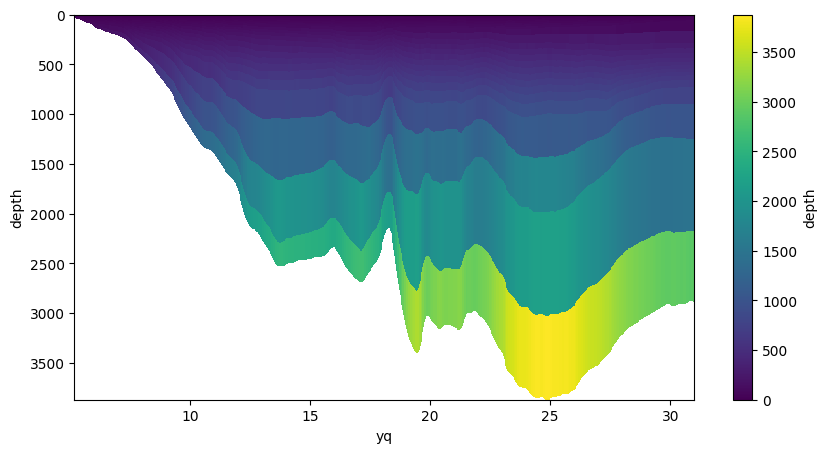

In [5]:
### Remapping vmo in density coordinates back to depth coordinates

### calculating thkcello from other variables
thkcello = ds.volcello/static.areacello
thk = thkcello.where(thkcello<1e10)
### shifting thkcello onto the vmo grid
thk_yq = grid.interp(thk.mean('time'), 'Y', boundary='extend').chunk({'z_l':-1})
### transforming thkcello as we did before for vmo
thk_rho2 = grid.transform(thk_yq.chunk({'z_l':-1}), target = rho2_axis, target_data=rho2,  method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

### cumulative sum of thickness to get the time averaged depth of an isopycnal
zrho = thk_rho2.mean('xh').cumsum('rho2')
### add new coordinate to the overturning
psi_so_offline.coords['depth'] = zrho

### plot the depth using transformed density coordinates
psi_so_offline.coords['depth'].plot(x='yq', y='depth',yincrease=False,figsize=(10,5))

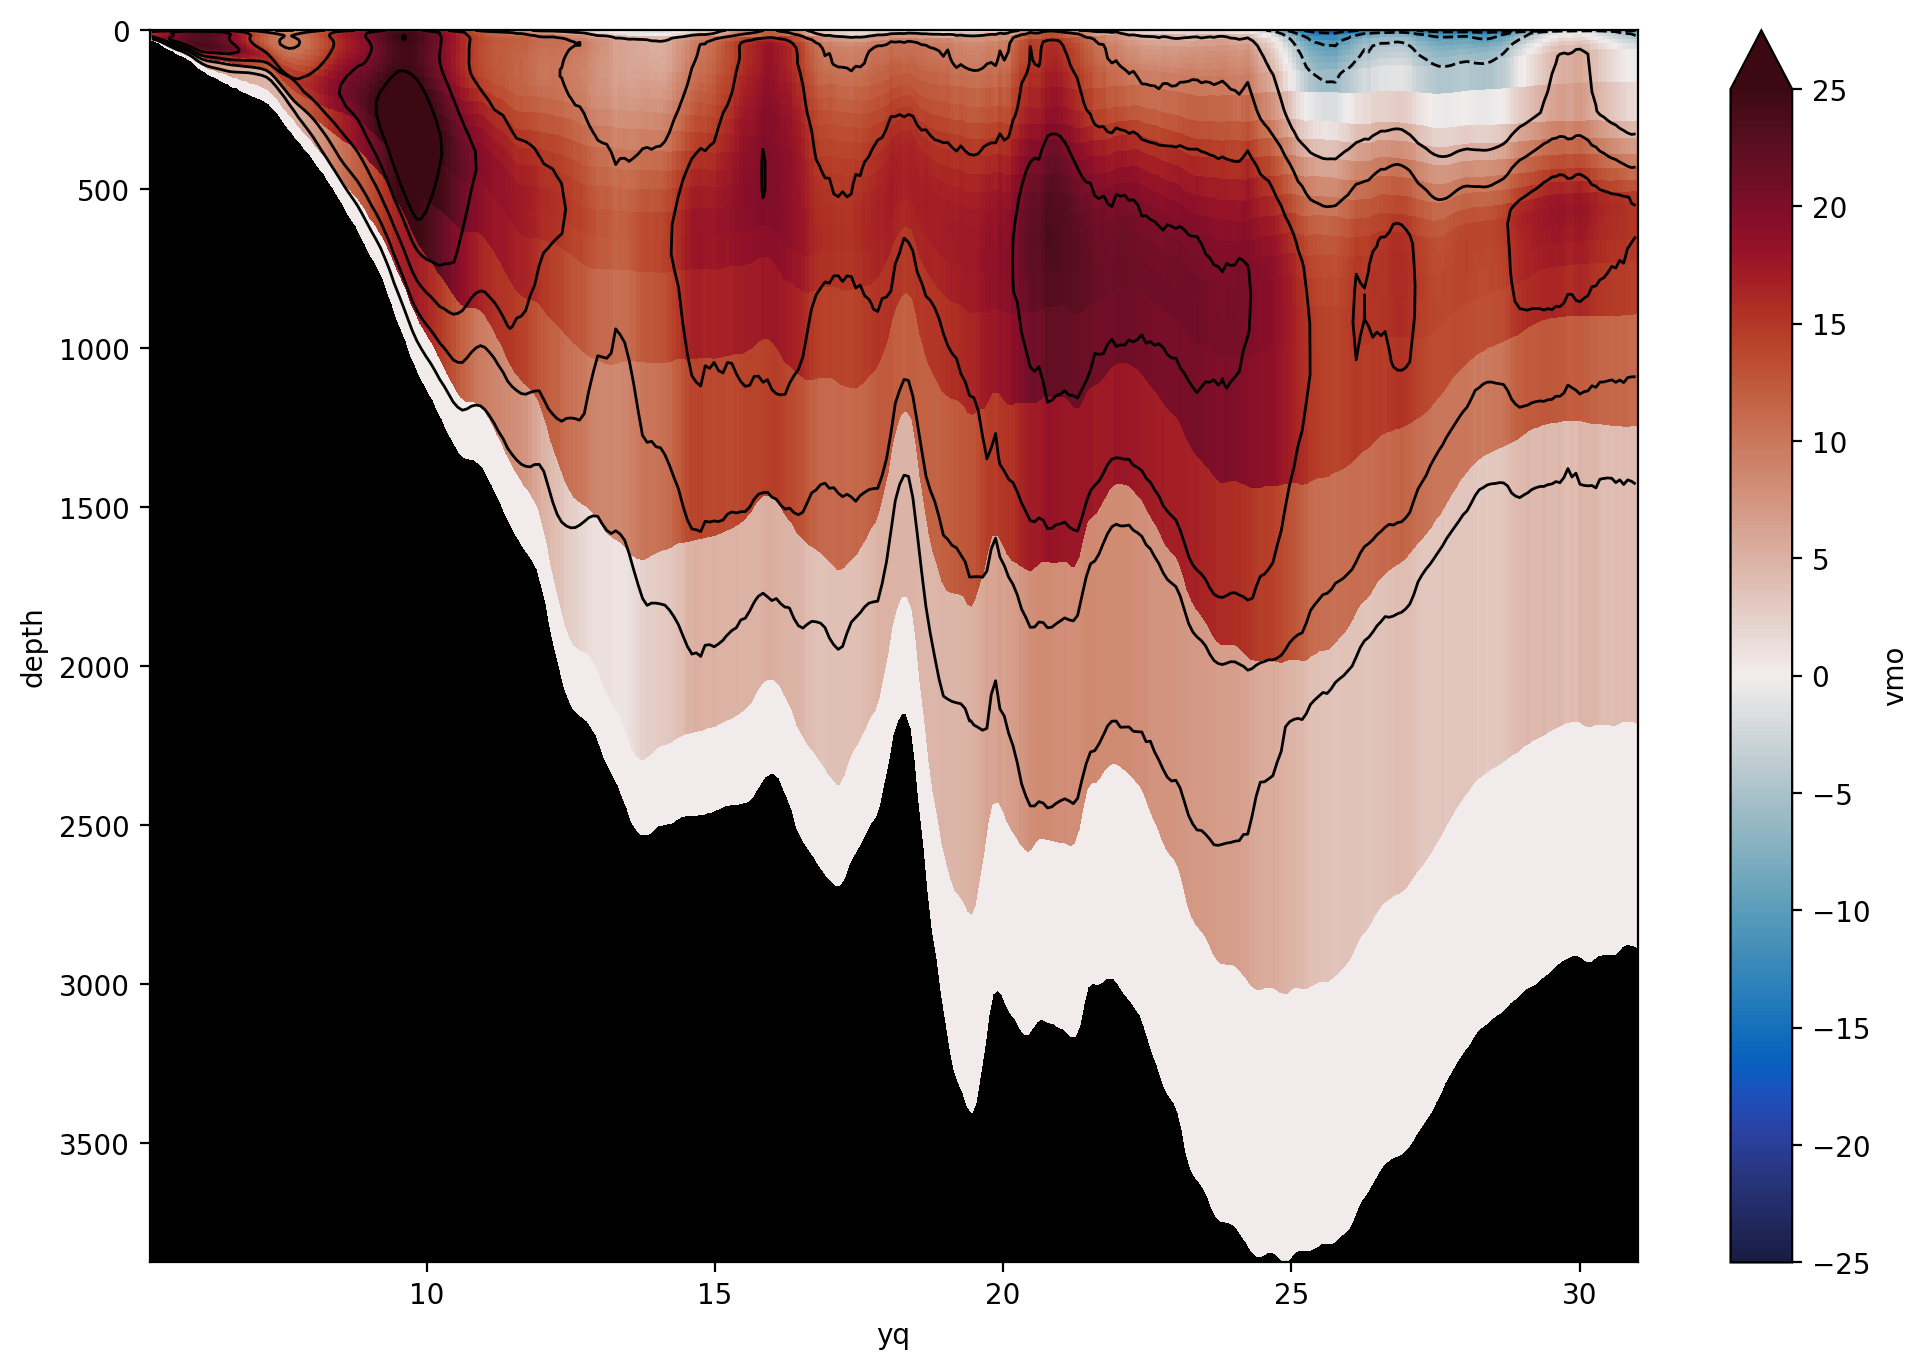

In [13]:
### plot the MOC in depth space

fig, ax = plt.subplots(figsize=(12,8),dpi=200)
psi_so_offline.plot(ax=ax,x='yq', y='depth',yincrease=False,vmin=-25,vmax=25,cmap=nanmasked,
                              cbar_kwargs={'ticks': np.arange(-30,35,5)})

psi_so_offline.plot.contour(ax=ax, x='yq', y='depth', yincrease=False,
                 levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]),
                 colors='k', linewidths=1)
ax.set_facecolor('black')
plt.show()

### Zonal overturning circulation

In [5]:
### Remapping umo to density coordinates

### from MOM6 analysis cookbook
rho2_axis = np.array([1013.750000,1028.500000,1029.242188,1029.718750,1030.179688,1030.625000,1031.054688,1031.468750,1031.867188,1032.250000,1032.617188,1032.968750,1033.304688,1033.625000
,1033.929688,1034.218750,1034.492188,1034.992188,1035.218750,1035.429688,1035.625000,1035.804688,1035.968750,1036.117188,1036.250000,1036.375000,1036.500000,1036.625000,1036.750000,
1036.875000,1037.000000,1037.125000,1037.250000,1037.656250])

### interpolate density values to vmo grid
rho2 = grid.interp(ds.Rho_cv.mean('time'), 'X', boundary='extend').rename('rho2').chunk({'z_l':-1})
### transform to rho coordinates using rho data on vmo points and rho axis
umo_rho2 = grid.transform(ds.umo.mean('time').chunk({'z_l':-1}), target = rho2_axis, target_data=rho2,  method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

### filter out any nan values
umo_so_offline = umo_rho2.where(umo_rho2<1e14)#.sel(rho2=slice(1033,1038))
### MOC calculation, converting to Sv
psi_so_offline = (umo_so_offline.sum('yh').cumsum('rho2') - umo_so_offline.sum('yh').sum('rho2'))/1035/1.0e6 + 0.1

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warn

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warn

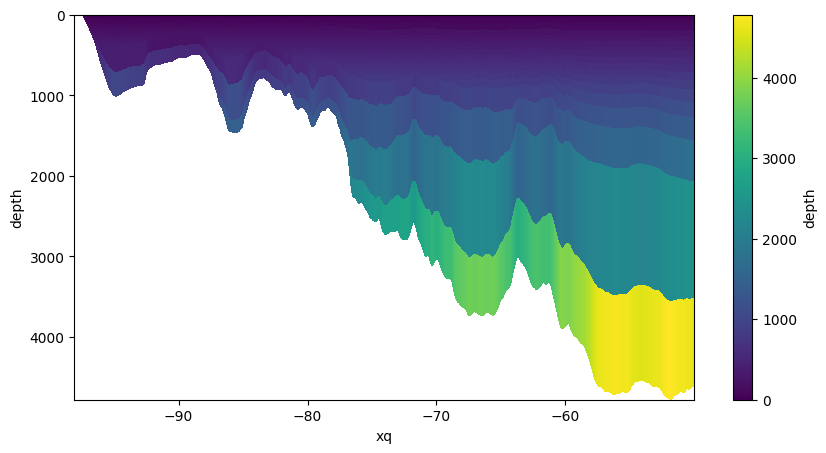

In [6]:
### Remapping vmo in density coordinates back to depth coordinates

### calculating thkcello from other variables
thkcello = ds.volcello/static.areacello
thk = thkcello.where(thkcello<1e10)
### shifting thkcello onto the vmo grid
thk_yq = grid.interp(thk.mean('time'), 'X', boundary='extend').chunk({'z_l':-1})
### transforming thkcello as we did before for vmo
thk_rho2 = grid.transform(thk_yq.chunk({'z_l':-1}), target = rho2_axis, target_data=rho2,  method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

### cumulative sum of thickness to get the time averaged depth of an isopycnal
zrho = thk_rho2.mean('yh').cumsum('rho2')
### add new coordinate to the overturning
psi_so_offline.coords['depth'] = zrho

### plot the depth using transformed density coordinates
psi_so_offline.coords['depth'].plot(x='xq', y='depth',yincrease=False,figsize=(10,5))

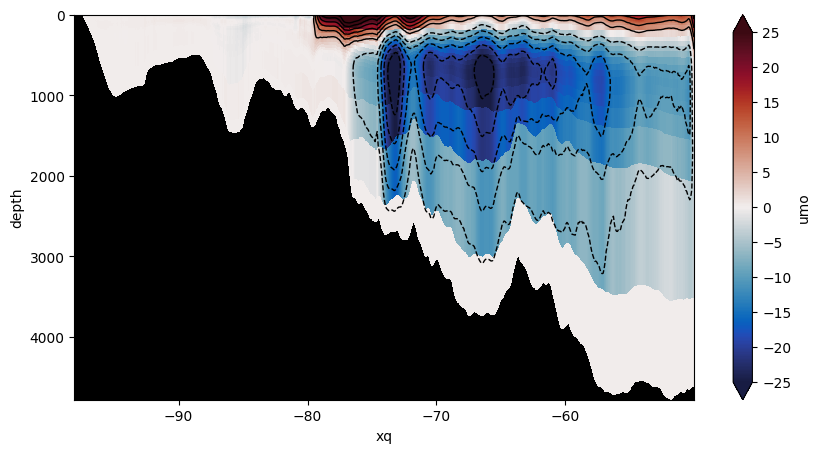

In [7]:
### plot the ZOC in depth space

fig, ax = plt.subplots(figsize=(10,5))
psi_so_offline.plot(ax=ax,x='xq', y='depth',yincrease=False,vmin=-25,vmax=25,cmap=nanmasked,
                              cbar_kwargs={'ticks': np.arange(-30,35,5)})

psi_so_offline.plot.contour(ax=ax, x='xq', y='depth', yincrease=False,
                 levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]),
                 colors='k', linewidths=1)
ax.set_facecolor('black')
plt.show()

In [5]:
# # psi = ds.vmo.sum('xh').cumsum('z_l') - ds.vmo.sum('xh').sum('z_l') 
# # psi_Sv = psi/1035/1e6
# # psi_Sv.mean('time').plot(x='yq',y='z_l',yincrease=False,cmap=nanmasked2)

# # plt.hist(ds.Rho_cv.flatten())
# xr.plot.hist(ds.Rho_cv.mean('time'),bins = np.linspace(1028, 1038, 101))
# ds

### Ekman transport
Calculate drag coefficient and land mask for wind stress first.

In [7]:
# ### loading the forcing data
data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/INPUT/MULTIYEAR-ERA5/ERA5_u10_1996_padded.nc' # 10 meter zonal wind
ds = xr.open_dataset(data_path,chunks='auto')
data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/INPUT/MULTIYEAR-ERA5/ERA5_v10_1996_padded.nc' # 10 meter meridional wind
ds = xr.merge([xr.open_dataset(data_path,chunks='auto'),ds])
ds = ds.sel(**{'latitude':slice(5.2,31),'longitude':slice(262,310)}) # crop to the caribbean region

## calculating drag coefficient 
U10 = np.sqrt(ds.u10**2 + ds.v10**2) # wind speed
C_d = U10.where(U10<3,1.25e-3) # kara et al. 2007 Cd
C_d = C_d.where((U10<6)&(U10>=3),(0.29 + 3.1/U10 + 7.7/U10**2)/1000) # yelland and taylor 1996
C_d = C_d.where((U10>=6)&(U10<26),(0.6 + 0.071*U10)/1000) # yelland et al. 1998
C_d = C_d.where(U10>=26,1.25e-3) # kara et al. 2007 Cd

# # ### calculating wind stress
tau = 1.3*C_d*U10**2 # 1.3 kg/m^3 is air density

### make land mask
land_mask = static.wet.interp(xh=ds.longitude-360, yh=ds.latitude, method="linear")
land_mask = land_mask.round()
land_mask[0,0:183]=0 # fix the bottom row

# nanmasked = plt.get_cmap('Greens').copy()
# nanmasked.set_bad('black')

# ### plot the wind stress
# fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)
# tau.mean('time').where(land_mask).plot(x='longitude',y='latitude',cmap=nanmasked,cbar_kwargs={'label':r'wind stress $\tau$ [N/m$^2$]'})
# ax.set_aspect('equal')

# tau.mean(['longitude','latitude']).plot(x='time')

Next, calculate the Ekman pumping/suction using the wind stress curl.

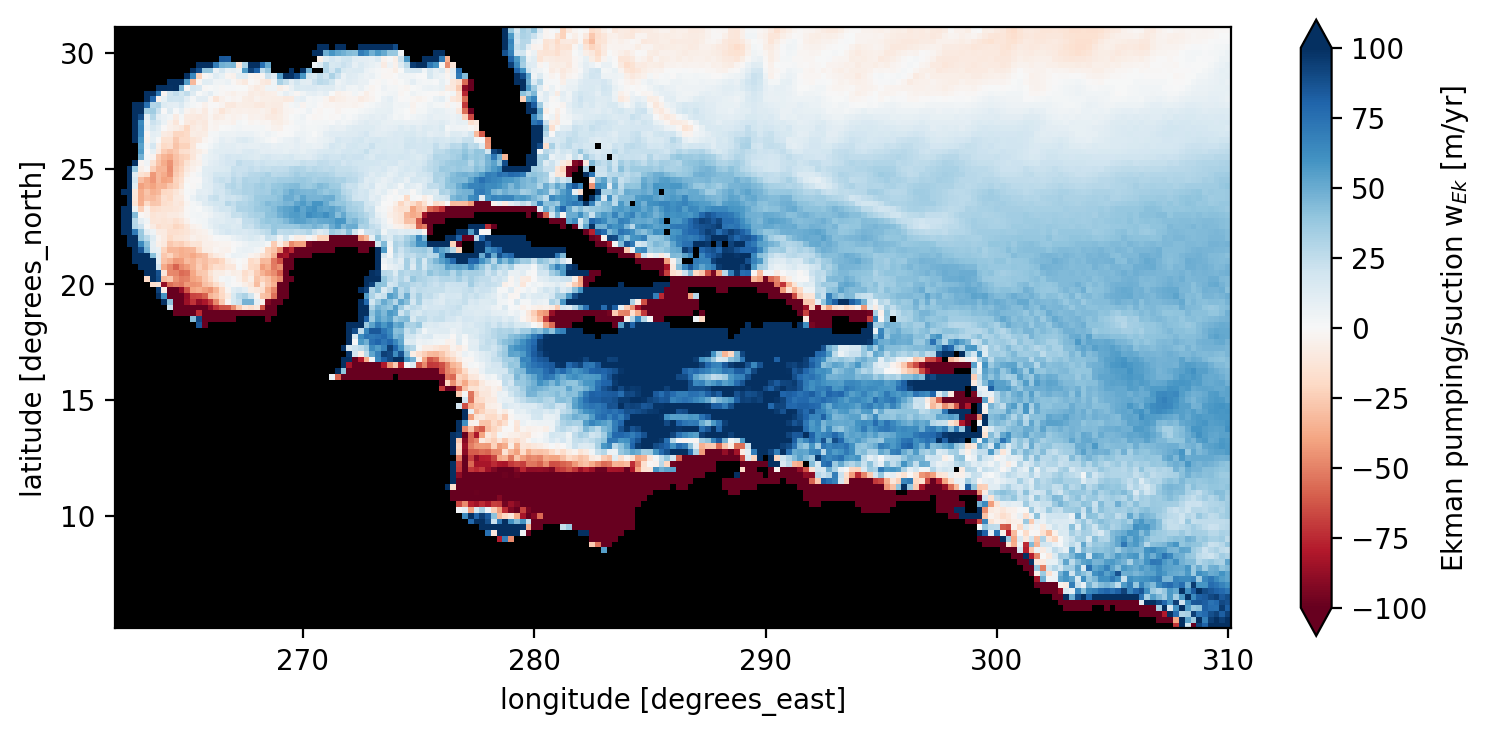

In [8]:
### calculating wind stress components

tau_x = 1.3*C_d*ds.u10**2 # 1.3 kg/m^3 is air density
tau_y = 1.3*C_d*ds.v10**2

##
# tau_x = 1.3*C_d*ds.u10*U10 # 1.3 kg/m^3 is air density
# tau_y = 1.3*C_d*ds.v10*U10

### calculating coriolis coefficient
f = 2*(7.2921e-5)*np.sin(np.tile(ds.latitude,(193,1)).T*np.pi/180) # 2 omega sin(lat)
ds['f'] = xr.DataArray(data=f,
                         coords={'latitude': ds.latitude,'longitude': ds.longitude},
                         dims=('latitude','longitude'))

### calculating ekman suction 
curl_tau = np.gradient(tau_y/ds.f,111.321*1000*0.25,axis=2) - np.gradient(tau_x/ds.f,111.321*1000*0.25,axis=1)
ds['curl_tau'] = xr.DataArray(data=curl_tau,
                         coords={'time':ds.time,'latitude': ds.latitude,'longitude': ds.longitude},
                         dims=('time','latitude','longitude'))
del curl_tau
w_Ek = 1/1035*ds.curl_tau*60*60*24*365 # m/day (check if negative is true, plot matches Marshall and Plumb w/ negative)

# ### plot the wind stress
fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)
w_Ek.mean('time').where(land_mask).plot(x='longitude',y='latitude',cmap=nanmasked2,cbar_kwargs={'label':r'Ekman pumping/suction w$_{Ek}$ [m/yr]'},vmin=-100,vmax=100)
ax.set_aspect('equal')

In [ ]:
# h_x = grid.interp(grid.derivative(static.depth_ocean,'X'),['X']) # use nondimensional distance
# h_y = grid.interp(grid.derivative(static.depth_ocean,'Y'),['Y']) # use nondimensional distance
# h_mag = np.sqrt(h_x**2 + h_y**2)

fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)
# nanmasked = plt.get_cmap('turbo_r').copy()
# nanmasked.set_bad('black')
# tau.mean('time').plot(x='xh',y='yh',norm=mpl.colors.SymLogNorm(linthresh=1e-5, linscale=1e-5,vmin=-1e-2, vmax=1e-2),cmap=nanmasked2,cbar_kwargs={'label':r'$\tau_B$ [m/s]','ticks':[-1e-2,-1e-3,-1e-4,0,1e-4,1e-3,1e-2]})
(1e6*ds.o2.isel(zl=depth_ind).mean('time')).plot(x='xh',y='yh',cmap=nanmasked,cbar_kwargs={'label':r'o2 [$\mu$mol/kg]'},vmin=0)
ax.set_title('bottom oxygen, w/ tides (1997 mean)')
ax.set_aspect('equal')

### Sandbox

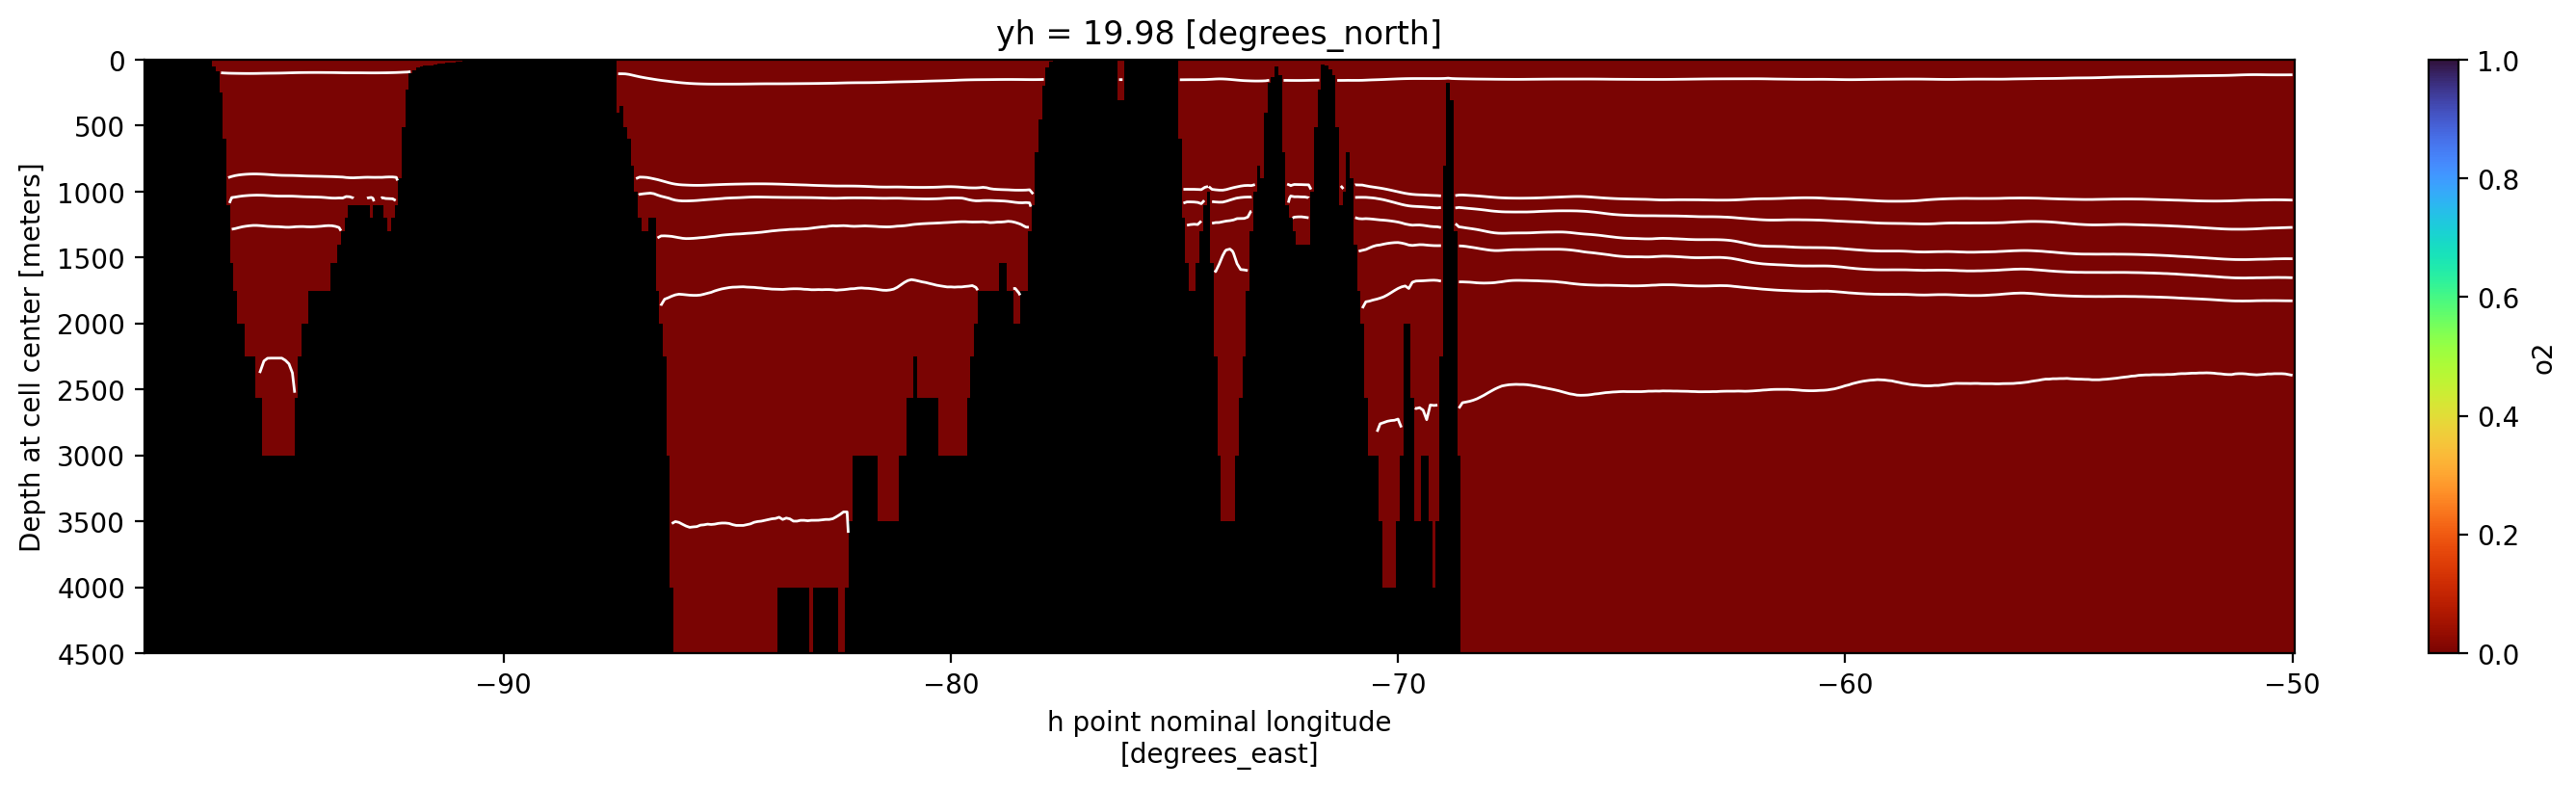

In [117]:
# fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=200)
# ds.v.isel(time=0,zl=45).plot(x='xh',y='yq',cmap=nanmasked2)
# ax.set_aspect('equal')

# ### zonal velocity
# fig, ax = plt.subplots(1, 1, figsize=(18,4))
# ds.u.isel(yh=200,time=0).plot(x='xq',y='zl',yincrease=False,vmin=-0.2,vmax=0.2,cmap=nanmasked,ax=ax) # deriv lands back on xh 
# ax.fill_between(ds.xq,static.depth_ocean.fillna(0.).isel(yh=200),7000*np.ones(601),color='black') # fake topography since we're in native coordinates
# ax.set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values + '  Latitude: {:0.2f}'.format(ds.yh[200].values) + '$^{\circ}$N')
# plt.show()

# ### meridional velocity
# fig, ax = plt.subplots(2, 1, figsize=(18,6),height_ratios=[1, 2],sharex=True,dpi=200)
# test = ds.v.where(static.wet_depth_yq).sel(xh=-73.75,method='nearest').sel(**{'yq': slice(18,22)}) #.where(static.wet_depth_yq)
# test.isel(zl=slice(0,35)).mean('time').plot(x='yq',y='zl',yincrease=False,cmap=nanmasked,vmin=-0.3,vmax=0.3,add_colorbar=False,ax=ax[0]) # deriv lands back on xh 
# im=test.isel(zl=slice(35,60)).mean('time').plot(x='yq',y='zl',yincrease=False,cmap=nanmasked,vmin=-0.3,vmax=0.3,add_colorbar=False,ax=ax[1]) # deriv lands back on xh 
# ax[1].set_title('')
# ax[0].set_xlabel('')
# ax[0].set_ylabel('')
# fig.subplots_adjust(hspace=0.05)
# fig.colorbar(im, ax=ax.ravel().tolist(),pad=0.01)
# # ax[0].fill_between(ds.yq,static.depth_ocean.fillna(0.).sel(xh=-67.5,method='nearest'),ds.zl[35].values*np.ones(343),color='black') # fake topography since we're in native coordinates
# # ax[1].fill_between(ds.yq,static.depth_ocean.fillna(0.).sel(xh=-67.5,method='nearest'),7000*np.ones(343),color='black') # fake topography since we're in native coordinates
# # ax[0].set_title(label='Date: ' + ds.time[130].dt.strftime('%Y-%m-%d').values + '  Longitude: {:0.2f}'.format(ds.xh.sel(xh=-64,method='nearest').values) + '$^{\circ}$E')
# plt.show()

# tracer
# fig, ax = plt.subplots(2, 1, figsize=(18,6),height_ratios=[1, 3],sharex=True,dpi=200)
fig, ax = plt.subplots(1, 1, figsize=(18,4),dpi=200)
test = ds.o2.sel(yh=19.98,method='nearest').mean('time')#.sel(**{'yh':slice(5,15)})
top=test.isel(z_l=slice(0,48)).plot(x='xh',y='z_l',yincrease=False,vmin=0,vmax=1,cmap=nanmasked)#,add_colorbar=False) # deriv lands back on xh 
ds.Rho_cv.sel(yh=19.98,method='nearest').isel(z_l=slice(0,48)).mean('time').plot.contour(x='xh',y='z_l',levels=[1034,1036.6, 1036.7,1036.8,1036.85,1036.9,1037],colors='white',linewidths=1,yincrease=False)
# im=test.isel(z_l=slice(25,None)).plot(x='xh',y='z_l',yincrease=False,vmin=0,vmax=1,cmap=nanmasked,add_colorbar=False,ax=ax[1]) # deriv lands back on xh 
# ds.MLD_003.isel(xh=300,time=210).plot(x='yh',ax=ax[0],color='olivedrab')
# ax[1].set_title('')
# ax[0].set_xlabel('')
# ax[0].set_ylabel('')
fig.subplots_adjust(hspace=0.05)
# fig.colorbar(im, ax=ax.ravel().tolist(),pad=0.01,label='o2 [$\mu$mol/kg]')
# ax[0].fill_between(ds.yh,static.depth_ocean.fillna(0.).sel(xh=-80,method='nearest'),ds.zl[35].values*np.ones(343),color='black') # fake topography since we're in native coordinates
# ax[1].fill_between(ds.yh,static.depth_ocean.fillna(0.).sel(xh=-80,method='nearest'),7000*np.ones(343),color='black') # fake topography since we're in native coordinates
# ax[0].set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values) #+ '  Latitude: {:0.2f}'.format(ds.yh.sel(xh=-86,method='nearest').values) + '$^{\circ}$E')
plt.show()

# def animate(frame):
#     top.set_array(test.isel(zl=slice(0,35),time=frame))
#     im.set_array(test.isel(zl=slice(35,None),time=frame))
#     ax[0].set_title(label='Date: ' + ds.time[frame].dt.strftime('%Y-%m-%d').values)
#     # plt.tight_layout()
                   
# ani = animation.FuncAnimation(fig, animate, frames=364)
# ani.save('/scratch/gpfs/CDEUTSCH/wchu/images/o2_caribbean_cayman.gif', writer='imagemagick', fps = 15) #Save animation as gif-file

# HTML(ani.to_jshtml())

In [ ]:
# ds.o2.sel(xh=-58,yh=8.7,zl=1600,method='nearest').plot(x='time')
fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)
(1e6*ds.btm_o2).mean('time').plot(x='xh',y='yh',cmap=nanmasked,cbar_kwargs={'label':'bottom oxygen [$\mu$mol/kg]'})
ax.set_aspect('equal')

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_979788/601615823.py:3: SyntaxWarning: invalid escape sequence '\m'
  (1e6*ds.btm_o2).mean('time').plot(x='xh',y='yh',cmap=nanmasked,cbar_kwargs={'label':'bottom oxygen [$\mu$mol/kg]'})


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_240676/4273993013.py:10: SyntaxWarning: invalid escape sequence '\m'
  cbar = plt.colorbar(im, orientation='vertical', label='sediment oxic Ndet \n remin flux [$\mu$mol/m$^2$/s]',pad=0.02)


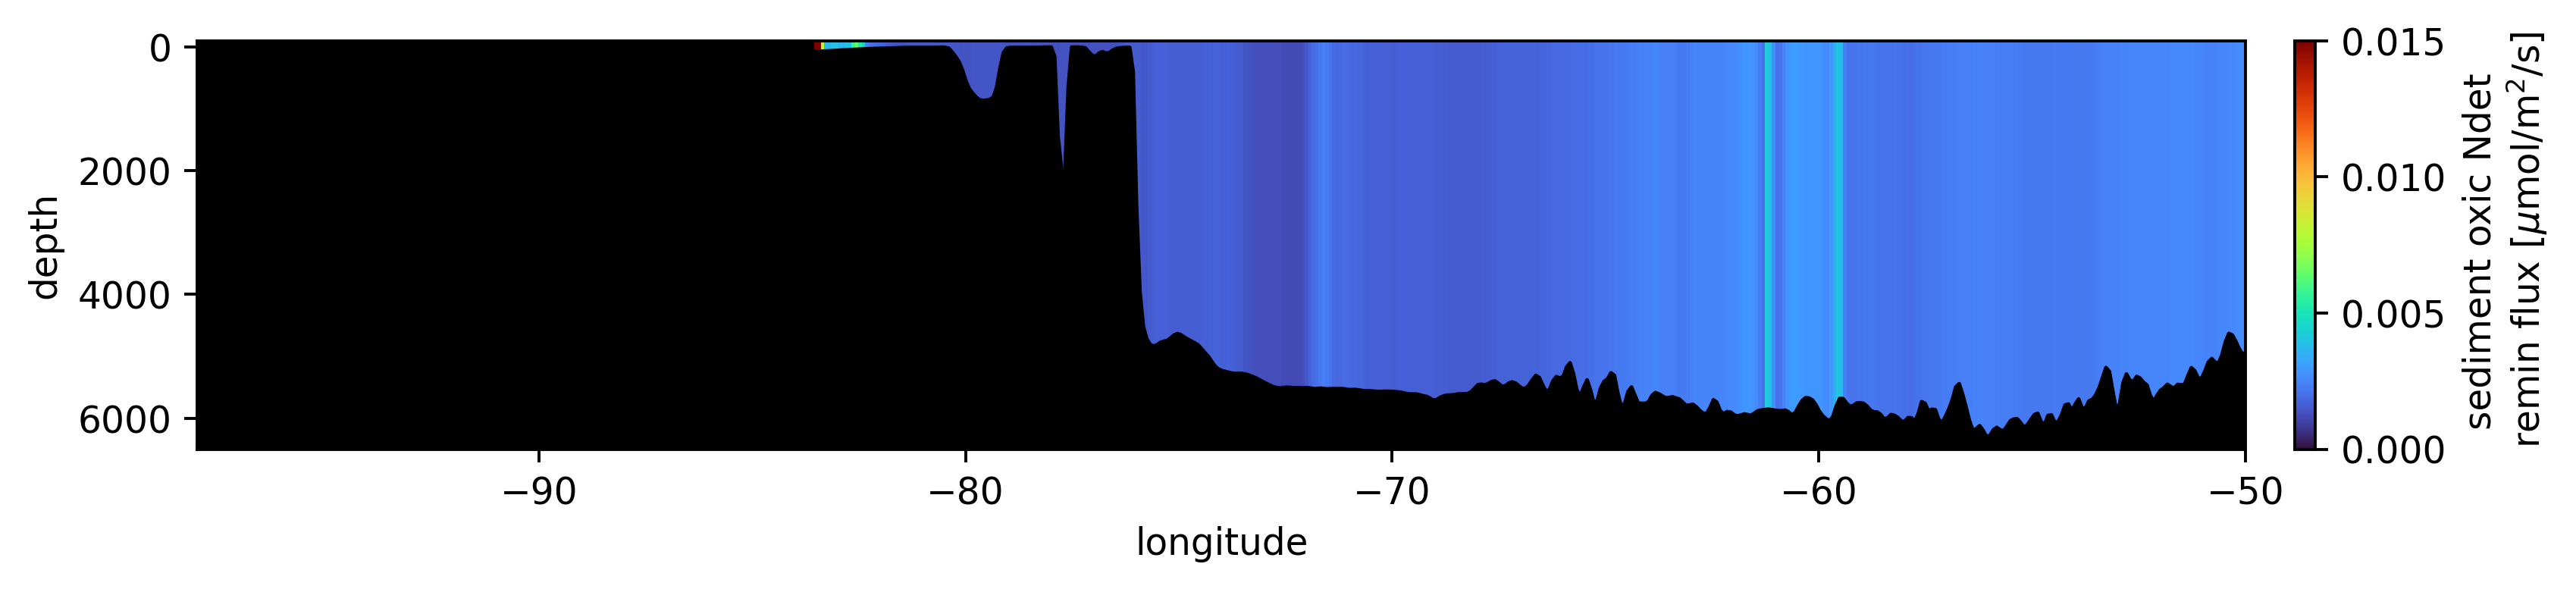

In [27]:
# fig, ax = plt.subplots(1, 1, figsize=(18,3),dpi=200)
test = 1e6*ds.fnoxic_sed.isel(time=180).sel(yh=13,method='nearest').values[np.newaxis,:] #[mol/m2/s]
# plt.imshow(test)

fig, ax = plt.subplots(1, 1, figsize=(12,2),dpi=350)
extent = [ds.xh[0],ds.xh[600],-100,6500]
im = ax.imshow(test, cmap=nanmasked, vmin=0,vmax=0.015,aspect="auto", extent=extent)
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
cbar = plt.colorbar(im, orientation='vertical', label='sediment oxic Ndet \n remin flux [$\mu$mol/m$^2$/s]',pad=0.02)
ax.fill_between(ds.xh,static.depth_ocean.fillna(0.).sel(yh=25,method='nearest'),6500*np.ones(601),color='black') # fake topography since we're in native coordinates
plt.gca().invert_yaxis()
plt.show()

In [ ]:
## u_int = grid.interp(ds.u.where(static.wet_depth_xq).mean('time').sel(zl=2000,method='nearest'),'X')
# v_int = grid.interp(ds.v.where(static.wet_depth_yq).mean('time').sel(zl=2000,method='nearest'),'Y')



# u_int = grid.interp(ds.u.mean('time').sel(z_l=800,method='nearest'),'X')
# v_int = grid.interp(ds.v.mean('time').sel(z_l=800,method='nearest'),'Y') 
# vel = np.sqrt(u_int**2 + v_int**2)
# ang = 180+np.degrees(np.arctan2(v_int,u_int))


# ds.v.where(static.wet_depth_yq).sel(zl=1200,method='nearest').mean('time').plot(x='xh',y='yq',cmap=nanmasked,vmin=-0.2,vmax=0.2) #.sel(**{'xh': slice(-76,-72),'yh': slice(18,22)})

# test = ds.o2min.sel(zl=200,method='nearest').mean('time')
test = 1e6*ds.o2.mean('time')
o2_x = grid.derivative(grid.interp(test,['X']),'X') # convert to mumol so [mumol/m]
o2_x_bound = o2_x.sel(z_l=static.depth,method='nearest')
# o2_y = grid.derivative(grid.interp(test,['Y']),'Y') # convert to mumol so [mumol/m]
# h_x = grid.derivative(grid.interp(static.depth,['X']),'X')
# h_y = grid.derivative(grid.interp(static.depth,['Y']),'Y')
# h_mag = np.sqrt(h_x**2 + h_y**2)
# divo2h = (o2_x*h_x + o2_y*h_y)/h_mag
# ang = 180+np.degrees(np.arctan2(o2_y*h_y,o2_x*h_x))

# fig, ax = plt.subplots(1, 1, figsize=(7,4),dpi=200)
# nanmasked2 = plt.get_cmap('cmo.phase').copy()
# nanmasked2.set_bad('black')
# colors = [(1,1,1,c) for c in np.linspace(0,1,100)]
# cmapwhite = mpl.colors.LinearSegmentedColormap.from_list('mycmap', colors, N=200)

# # plot angles point in direction of increasing o2
# # ang.where(static.wet_depth.sel(zl=200,method='nearest')).plot(x='xh',y='yh',cmap=nanmasked2,cbar_kwargs={'label':'velocity angle'})
# # vel.where(static.wet_depth.sel(zl=200,method='nearest')).plot(x='xh',y='yh',vmin=0,vmax=0.5,cmap=cmapwhite,add_colorbar=False)
# ang.plot(x='xh',y='yh',cmap=nanmasked2,cbar_kwargs={'label':'velocity angle'})
# vel.plot(x='xh',y='yh',vmin=0,vmax=0.5,cmap=cmapwhite,add_colorbar=False)
# ax.set_title('velocity at {:0.2f} m depth'.format(ds.z_l.sel(z_l=800,method='nearest')))
# ax.set_aspect('equal')

In [48]:
# btm_vol = ds.volcello.isel(zl=depth_ind).compute()
# btm_vol
# ds.areacello
# tend2.o2h_tendency

In [20]:
ds

<xarray.Dataset>
Dimensions:                         (xh: 601, yh: 343, zl: 75, time: 31, nv: 2,
                                     zi: 76, xq: 601, yq: 343)
Coordinates:
  * xh                              (xh) float64 -98.0 -97.92 ... -50.08 -50.0
  * yh                              (yh) float64 5.273 5.352 ... 30.94 31.01
  * zl                              (zl) float64 1.0 3.0 ... 6.125e+03 6.375e+03
  * time                            (time) datetime64[ns] 1997-01-01T12:00:00...
  * nv                              (nv) float64 1.0 2.0
  * zi                              (zi) float64 0.0 2.0 ... 6.25e+03 6.5e+03
  * xq                              (xq) float64 -98.04 -97.96 ... -50.12 -50.04
  * yq                              (yq) float64 5.233 5.312 ... 30.9 30.97
Data variables: (12/39)
    temp                            (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    Th_tendency                     (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    T_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    T_tendency_vert_remap           (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    boundary_forcing_heat_tendency  (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    diabatic_heat_tendency          (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    ...                              ...
    time_bnds                       (time, nv) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    dxt                             (yh, xh) float64 dask.array<chunksize=(343, 601), meta=np.ndarray>
    dyt                             (yh, xh) float64 dask.array<chunksize=(343, 601), meta=np.ndarray>
    areacello                       (yh, xh) float64 dask.array<chunksize=(343, 601), meta=np.ndarray>
    depth_ocean                     (yh, xh) float32 dask.array<chunksize=(343, 601), meta=np.ndarray>
    wet                             (yh, xh) float32 dask.array<chunksize=(343, 601), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             CEFI_NWA12_COBALT_V1
    associated_files:  areacello: 19970101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [18]:
ds

<xarray.Dataset>
Dimensions:                         (xh: 601, yh: 343, zl: 75, time: 10, nv: 2,
                                     zi: 76, xq: 601, yq: 343)
Coordinates:
  * xh                              (xh) float64 -98.0 -97.92 ... -50.08 -50.0
  * yh                              (yh) float64 5.273 5.352 ... 30.94 31.01
  * zl                              (zl) float64 1.0 3.0 ... 6.125e+03 6.375e+03
  * time                            (time) datetime64[ns] 1997-01-01T12:00:00...
  * nv                              (nv) float64 1.0 2.0
  * zi                              (zi) float64 0.0 2.0 ... 6.25e+03 6.5e+03
  * xq                              (xq) float64 -98.04 -97.96 ... -50.12 -50.04
  * yq                              (yq) float64 5.233 5.312 ... 30.9 30.97
Data variables: (12/39)
    temp                            (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    Th_tendency                     (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    T_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    T_tendency_vert_remap           (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    boundary_forcing_heat_tendency  (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    diabatic_heat_tendency          (time, zl, yh, xh) float32 dask.array<chunksize=(2, 75, 343, 601), meta=np.ndarray>
    ...                              ...
    time_bnds                       (time, nv) datetime64[ns] dask.array<chunksize=(10, 2), meta=np.ndarray>
    dxt                             (yh, xh) float64 dask.array<chunksize=(343, 601), meta=np.ndarray>
    dyt                             (yh, xh) float64 dask.array<chunksize=(343, 601), meta=np.ndarray>
    areacello                       (yh, xh) float64 dask.array<chunksize=(343, 601), meta=np.ndarray>
    depth_ocean                     (yh, xh) float32 dask.array<chunksize=(343, 601), meta=np.ndarray>
    wet                             (yh, xh) float32 dask.array<chunksize=(343, 601), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             CEFI_NWA12_COBALT_V1
    associated_files:  areacello: 19970101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1940085/1004255611.py:15: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('longitude [$\degree$E]')
/tmp/ipykernel_1940085/1004255611.py:16: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('latitude [$\degree$N]')


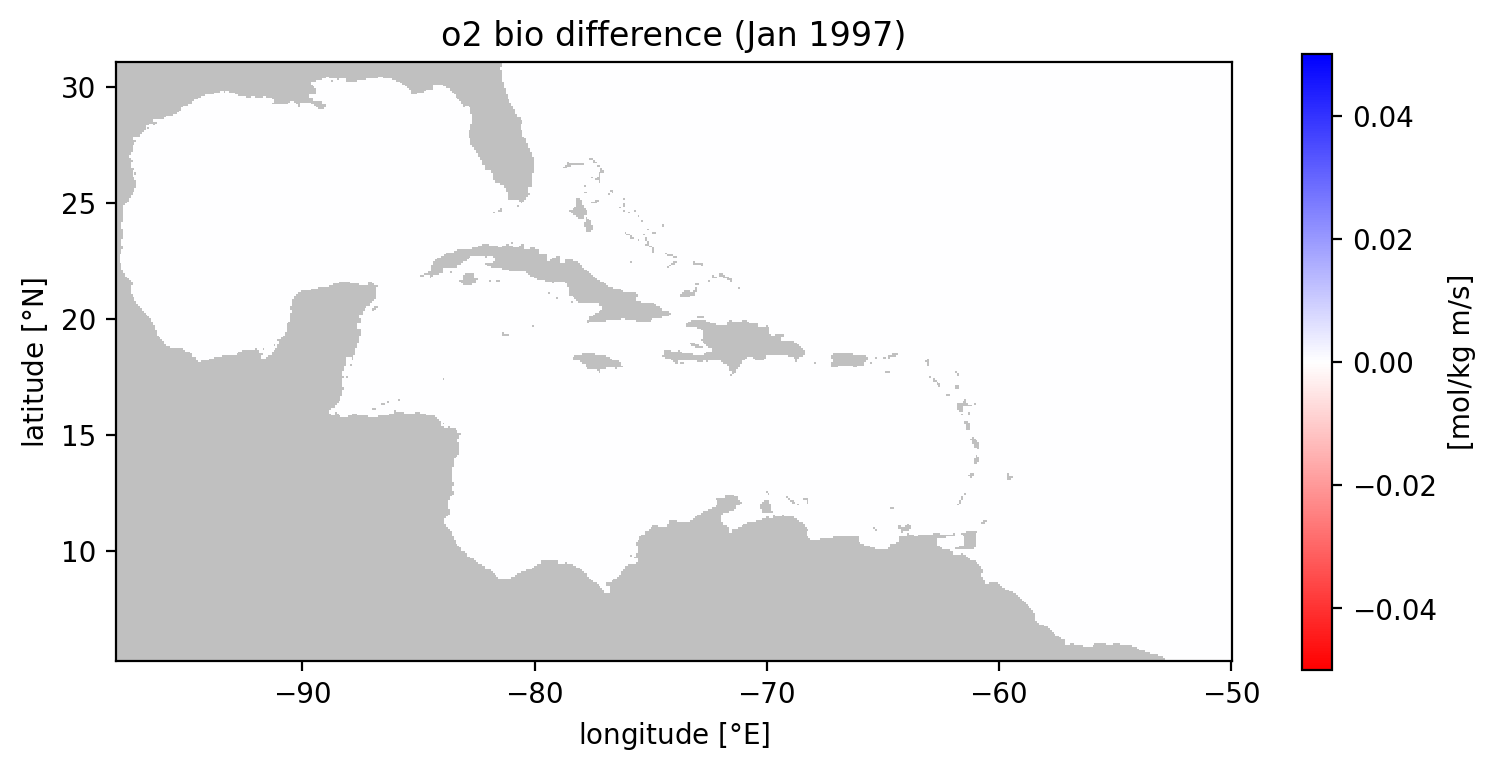

In [7]:
nanmasked = plt.get_cmap('bwr_r').copy()
nanmasked.set_bad('silver')

# o2h_vert = ds.o2h_tendency.sum('zl').compute()
# adv_vert = (ds.o2_advection_xy + ds.o2h_tendency_vert_remap).sum('zl').compute()
# diff_vert = ds.o2_vdiffuse_impl.sum('zl').compute()
# bio_vert = (ds.jo2/1035).sum('zl').compute()
# volume_tend= tend2.o2h_tendency*ds.areacello
# fluxes = hadv2.o2_advection_xy + vadv2.o2h_tendency_vert_remap + diff2.o2_vdiffuse_impl + bio2.jo2

fig, ax = plt.subplots(1, 1, figsize=(9,4),dpi=200)
# gradho2_not.mean('time').plot(x='xh',y='yh',cmap=nanmasked,cbar_kwargs={r'label':'o$_2$ [$\mu$mol/kg]'}) vmin=-1e-8,vmax=1e-8,
(ds.o2 - dsnot.o2).isel(zl=depth_ind).mean('time').plot(x='xh',y='yh',cmap=nanmasked,cbar_kwargs={'label':'[mol/kg m/s]'}) #,cbar_kwargs={'label':r'$\nabla$O$_2 \cdot \hat{n}$ [$\mu$mol/kg/m]'}
# (gradho2-gradho2_not).mean('time').plot(x='xh',y='yh',cbar_kwargs={'label':r'$\nabla$H/|$\nabla$H| $\cdot\nabla_{ND}$O$_2$ [$\mu$mol/kg]'},cmap=nanmasked,vmin=-100,vmax=100)
ax.set_xlabel('longitude [$\degree$E]')
ax.set_ylabel('latitude [$\degree$N]')
ax.set_title('o2 bio difference (Jan 1997)')
# ax.set_title('tide - no tide oxygen (1997 mean) at ' + str(np.round(ds.zl[74].values,2)) + ' m depth')
ax.set_aspect('equal')

In [11]:
meantend = tend2.o2h_tendency.mean('time')
# meantend.plot(x='xh',y='yh',vmin=-2e-11,vmax=2e-11,cmap=nanmasked)
meantend_xy = meantend.where(meantend<=-2e-11).stack(xy=('xh','yh'))
meantend_xy = meantend_xy.dropna('xy')#.o2h_tendency
# # meantend_xy

meanhadv_xy = hadv2.o2_advection_xy.mean('time').where(meantend<=-2e-11).stack(xy=('xh','yh'))
meanhadv_xy = meanhadv_xy.dropna('xy')#.o2h_tendency

meanvadv_xy = vadv2.o2h_tendency_vert_remap.mean('time').where(meantend<=-2e-11).stack(xy=('xh','yh'))
meanvadv_xy = meanvadv_xy.dropna('xy')#.o2h_tendency

meandiff_xy = diff2.o2_vdiffuse_impl.mean('time').where(meantend<=-2e-11).stack(xy=('xh','yh'))
meandiff_xy = meandiff_xy.dropna('xy')#.o2h_tendency

meanbio_xy = bio2.jo2.mean('time').where(meantend<=-2e-11).stack(xy=('xh','yh'))
meanbio_xy = meanbio_xy.dropna('xy')#.o2h_tendency

(0.0, 100.0)

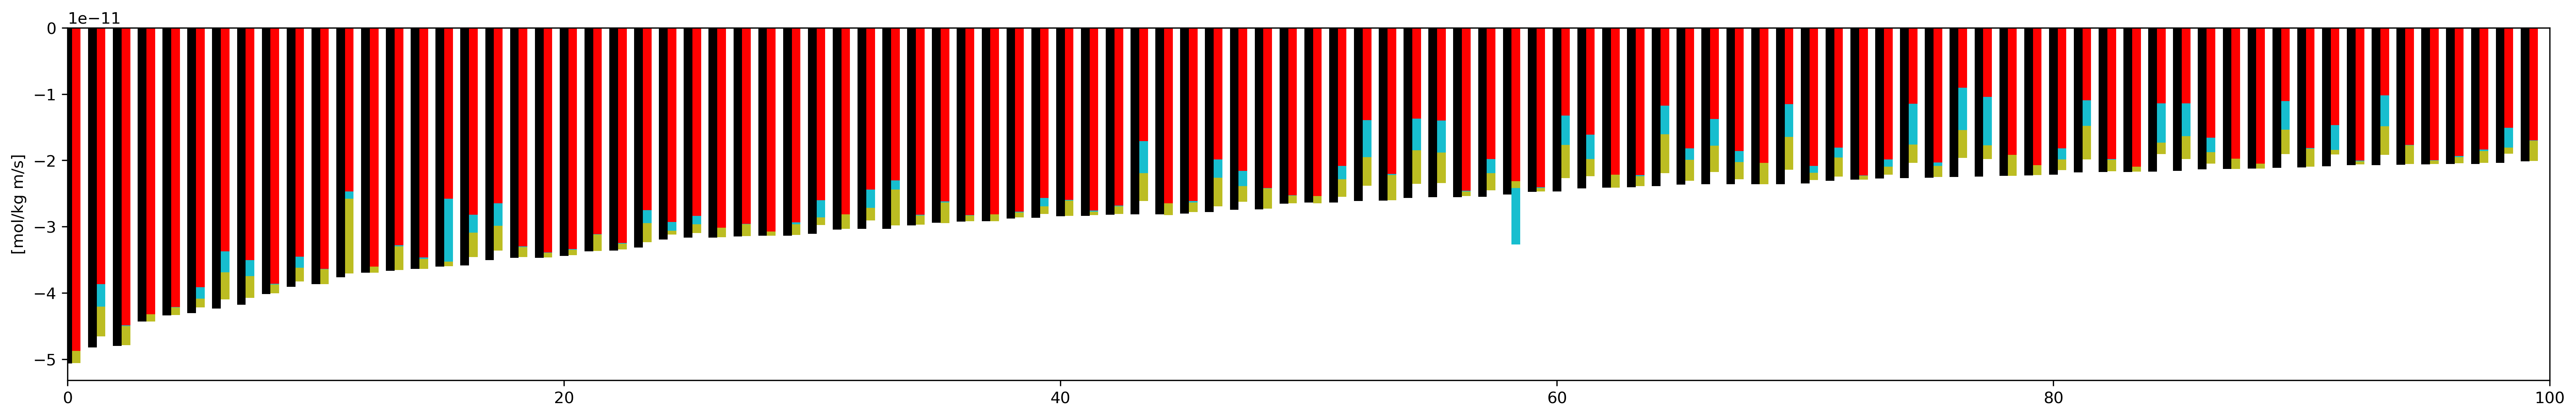

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(28,4),dpi=300)
test = meantend_xy.isel(xy=slice(0,100)).sortby(meantend_xy.isel(xy=slice(0,100))).compute()
plt.bar(np.arange(0,100), meantend_xy.isel(xy=slice(0,100)).sortby(test).values, 0.35, color='black')
# # plt.bar(np.arange(0,10)+0.35, meanhadv_xy.o2h_tendency.isel(xy=slice(0,10)).values, 0.35, color='red')
# # plt.bar(np.arange(0,10)+0.70, meanvadv_xy.o2h_tendency.isel(xy=slice(0,10)).values, 0.35, color='pink')
plt.bar(np.arange(0,100)+0.35, (meanhadv_xy + meanvadv_xy).isel(xy=slice(0,100)).sortby(test).values, 0.35, color='red')
plt.bar(np.arange(0,100)+0.35, meandiff_xy.isel(xy=slice(0,100)).sortby(test).values, 0.35, bottom=(meanhadv_xy + meanvadv_xy).isel(xy=slice(0,100)).sortby(test).values, color='tab:cyan')
plt.bar(np.arange(0,100)+0.35, meanbio_xy.isel(xy=slice(0,100)).sortby(test).values, 0.35, bottom=(meanhadv_xy + meanvadv_xy + meandiff_xy).isel(xy=slice(0,100)).sortby(test).values, color='tab:olive')
plt.ylabel('[mol/kg m/s]')
plt.xlim([0,100])

[Text(1, 0, 'tend'), Text(2, 0, 'adv'), Text(3, 0, 'diff'), Text(4, 0, 'bio')]

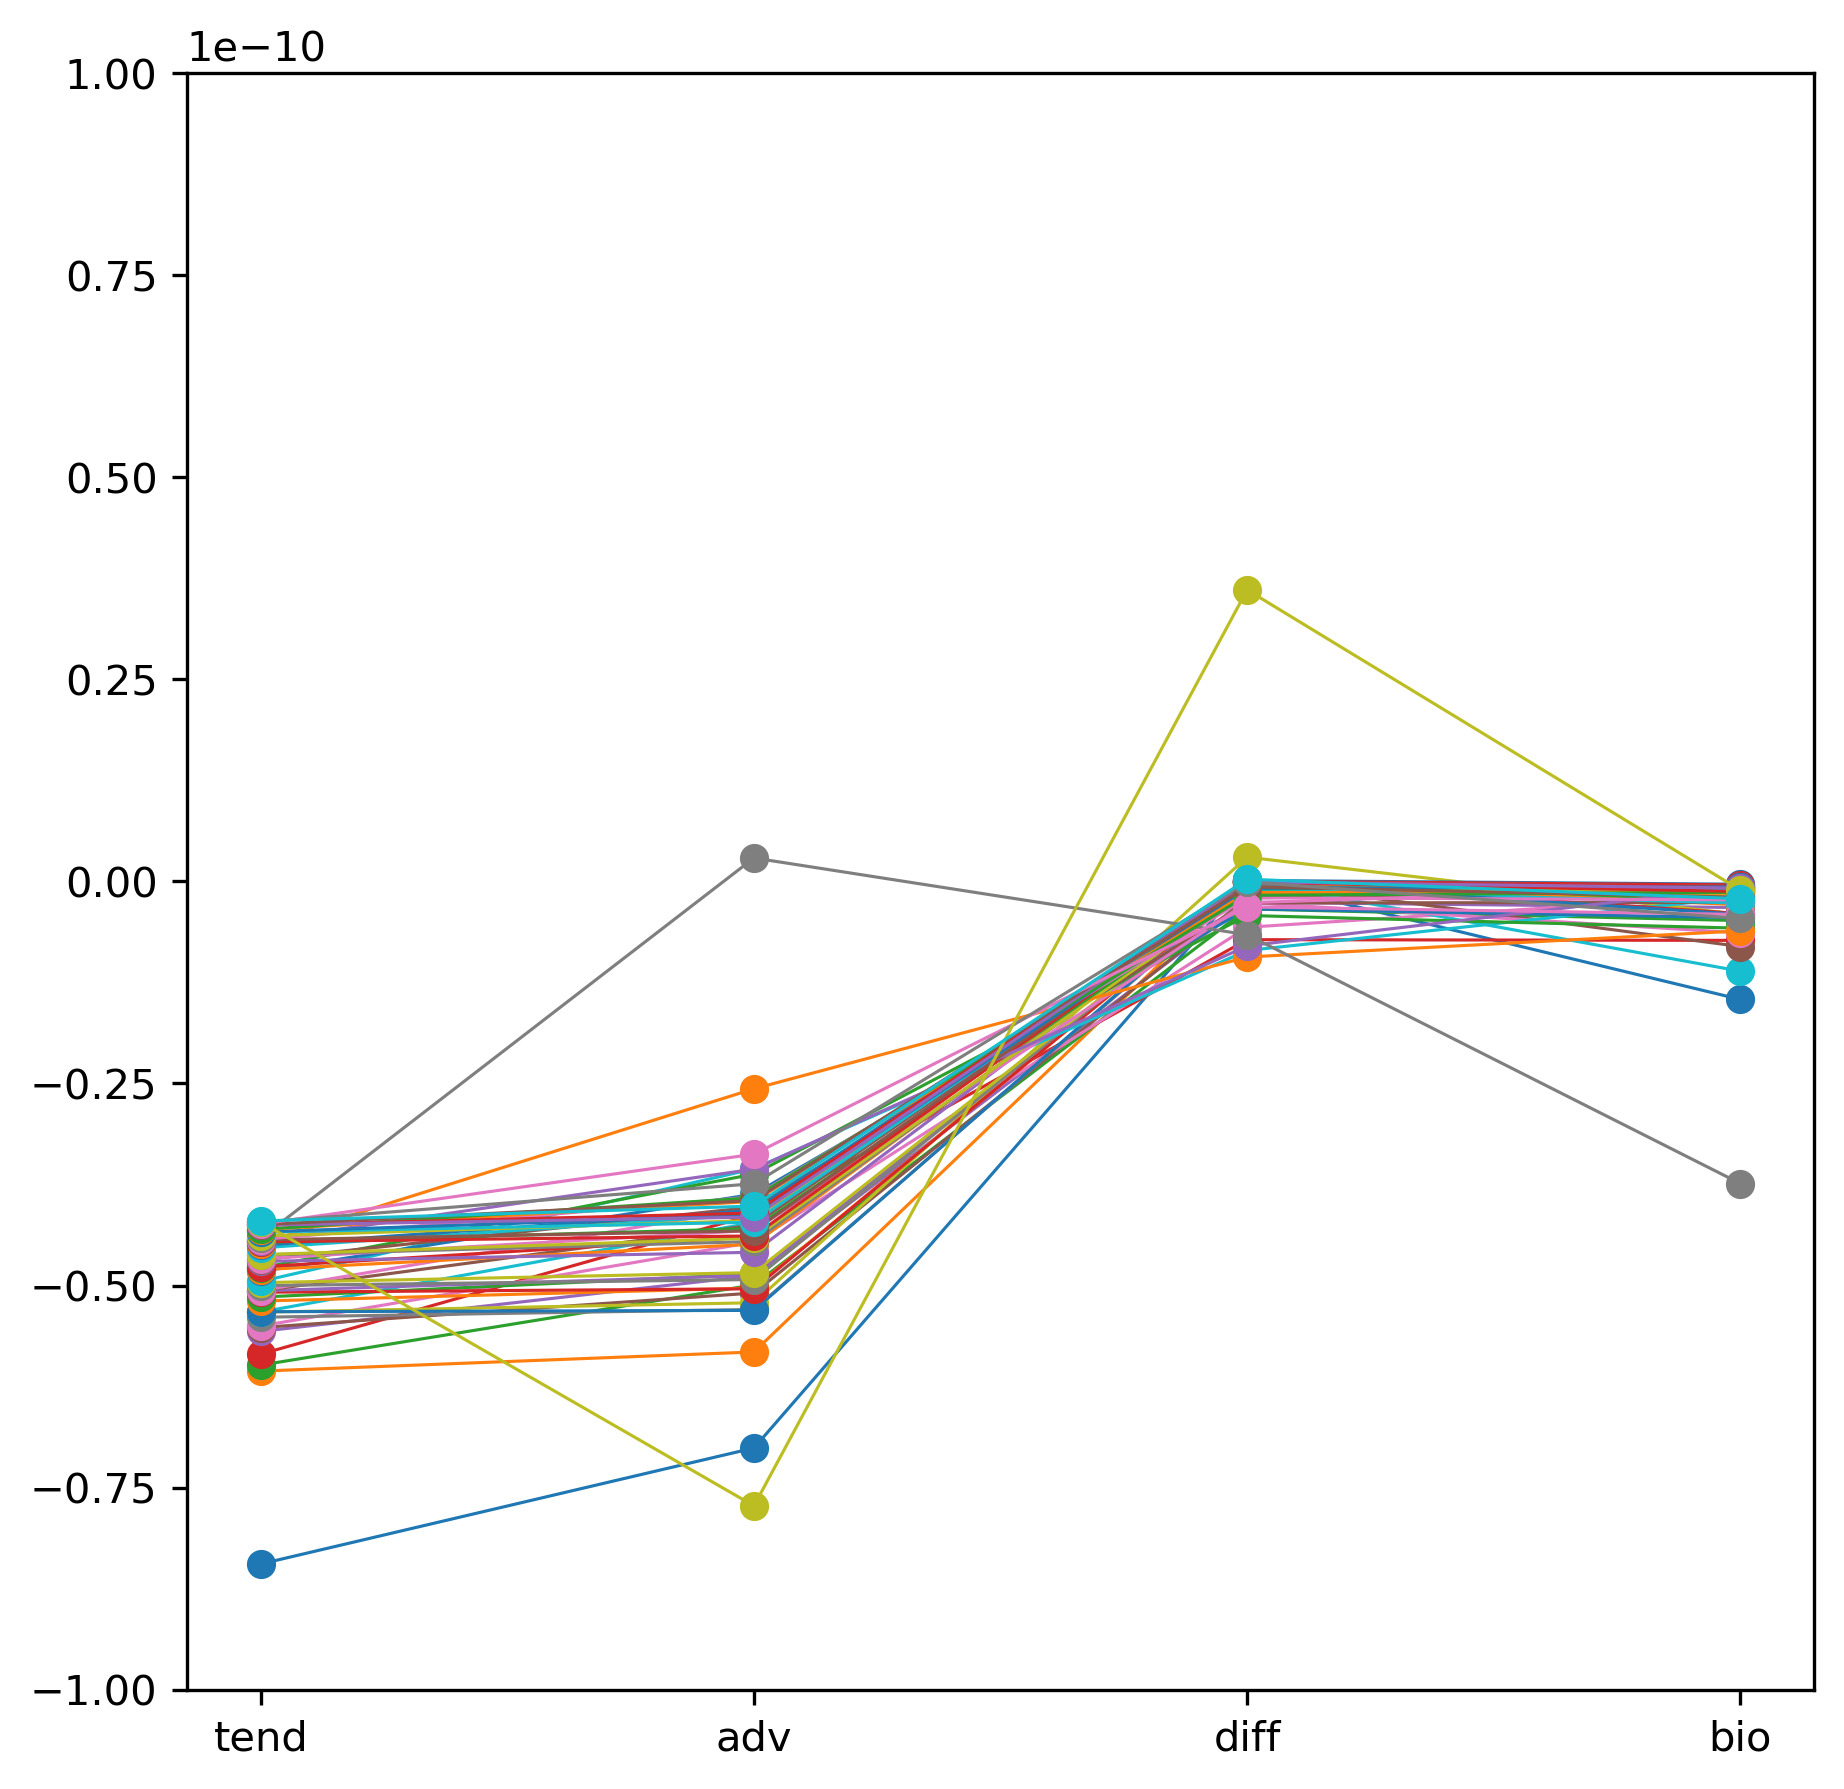

In [21]:
# plt.scatter(np.ones(100),meantend_xy.isel(xy=slice(0,100)))
# plt.scatter(2*np.ones(100),meanhadv_xy.isel(xy=slice(0,100))+ meanvadv_xy.isel(xy=slice(0,100)))
# plt.scatter(3*np.ones(100),meandiff_xy.isel(xy=slice(0,100)))
# plt.scatter(4*np.ones(100),meanbio_xy.isel(xy=slice(0,100)))

# test = xr.concat([meantend_xy.sortby(meantend_xy), meanhadv_xy.sortby(meantend_xy) + meanvadv_xy.sortby(meantend_xy), meandiff_xy.sortby(meantend_xy), meanbio_xy.sortby(meantend_xy)],dim='flux')

fig, ax = plt.subplots(1, 1, figsize=(7,7),dpi=300)
plt.plot(list(range(1,5)),test.isel(xy=slice(0,50)),linestyle='-',marker='o',linewidth=0.75);
plt.ylim([-1e-10,1e-10])
ax.set_xticks(list(range(1,5)))
ax.set_xticklabels(['tend','adv','diff','bio'])

In [36]:
# (ds.Rho_cv-1000).where((ds.Rho_cv-1000<=27.70)).isel(time=593,zl=50).plot(x='xh',y='yh')
# mean_temp = ds.temp.mean('time').compute()
# mean_salt = ds.salt.mean('time').compute()

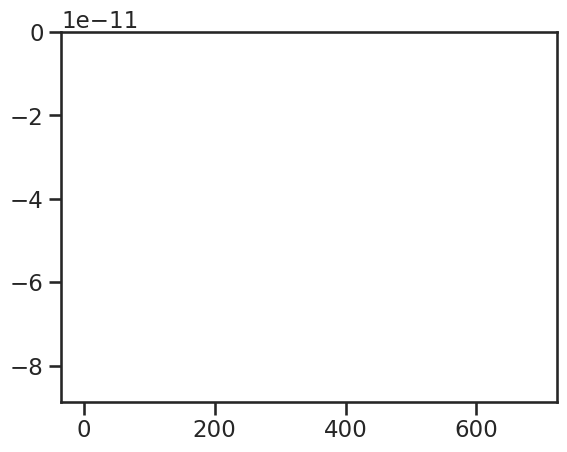

In [23]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 0.35
    epsilon = .015
    line_width = 1
    opacity = 0.7
    first_bar_positions = np.arange(690)
    neg_bar_positions = pos_bar_positions + bar_width

    # make bar plots
    plt.bar(pos_bar_positions, meantend_xy.o2h_tendency.values, bar_width,
                              color='red',
                              label='HPV+ Mutations')
    # hpv_pos_cna_bar = plt.bar(pos_bar_positions, pos_cna_pcts, bar_width-epsilon,
    #                           bottom=pos_mut_pcts,
    #                           alpha=opacity,
    #                           color='white',
    #                           edgecolor='#ED0020',
    #                           linewidth=line_width,
    #                           hatch='//',
    #                           label='HPV+ CNA')
    # hpv_pos_both_bar = plt.bar(pos_bar_positions, pos_both_pcts, bar_width-epsilon,
    #                            bottom=pos_cna_pcts+pos_mut_pcts,
    #                            alpha=opacity,
    #                            color='white',
    #                            edgecolor='#ED0020',
    #                            linewidth=line_width,
    #                            hatch='0',
    #                            label='HPV+ Both')
    # hpv_neg_mut_bar = plt.bar(neg_bar_positions, neg_mut_pcts, bar_width,
    #                           color='#0000DD',
    #                           label='HPV- Mutations')
    # hpv_neg_cna_bar = plt.bar(neg_bar_positions, neg_cna_pcts, bar_width-epsilon,
    #                           bottom=neg_mut_pcts,
    #                           color="white",
    #                           hatch='//',
    #                           edgecolor='#0000DD',
    #                           ecolor="#0000DD",
    #                           linewidth=line_width,
    #                           label='HPV- CNA')
    # hpv_neg_both_bar = plt.bar(neg_bar_positions, neg_both_pcts, bar_width-epsilon,
    #                            bottom=neg_cna_pcts+neg_mut_pcts,
    #                            color="white",
    #                            hatch='0',
    #                            edgecolor='#0000DD',
    #                            ecolor="#0000DD",
    #                            linewidth=line_width,
    #                            label='HPV- Both')
    # plt.xticks(neg_bar_positions, genes, rotation=45)
    # plt.ylabel('Percentage of Samples')
    # plt.legend(loc='best')
    # sns.despine()

In [39]:
## do parallel cooordinates plot

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3945887/2972767819.py:8: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('longitude [$\degree$E]')
/tmp/ipykernel_3945887/2972767819.py:9: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('latitude [$\degree$N]')


Text(0, 0.5, 'latitude [$\\degree$N]')

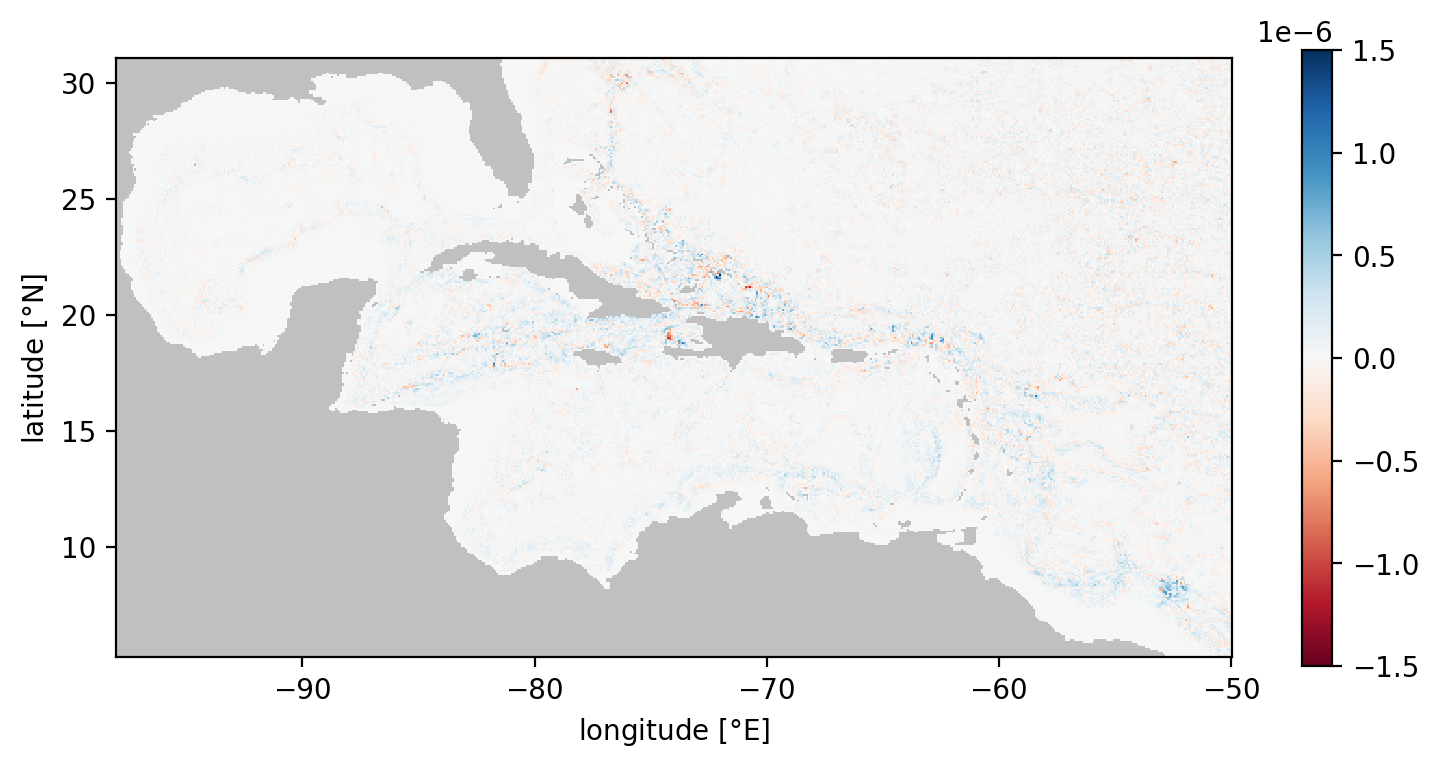

In [26]:
# diff = -tend[1:,:,:] + hadv[1:,:,:] + vadv[1,:,:] + diff[1:,:,:] + bio[1,:,:] 
nanmasked = plt.get_cmap('RdBu').copy()
nanmasked.set_bad('silver')
fig, ax = plt.subplots(1, 1, figsize=(9,4),dpi=200)
plt.pcolormesh(ds.xh,ds.yh,np.mean(diff[1:,:,:],axis=0),cmap=nanmasked,vmin=-1.5e-6,vmax=1.5e-6)
plt.colorbar()
ax.set_aspect('equal')
ax.set_xlabel('longitude [$\degree$E]')
ax.set_ylabel('latitude [$\degree$N]')

In [9]:
# hadv = ds.o2_advection_xy.isel(zl=depth_ind).compute()
# print('hadv done')
# vadv = ds.o2h_tendency_vert_remap.isel(zl=depth_ind).compute()
# print('vadv done')
# diff = ds.o2_vdiffuse_impl.isel(zl=depth_ind).compute()
# print('diff done')
bio2 = (ds.jo2_plus_btm.isel(zl=depth_ind)/1035).compute()
print('bio done')
# tend = ds.o2h_tendency.isel(zl=depth_ind).compute()
# print('tend done')
# ds .isel(xh=100,yh=216,zl=19)

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 28.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


bio done


In [54]:
# %time
# hadv2 = ds.o2_advection_xy.isel(zl=depth_ind).compute()
# print('hadv done')
# vadv2 = ds.o2h_tendency_vert_remap.isel(zl=depth_ind).compute()
# print('vadv done')
# diff2 = ds.o2_vdiffuse_impl.isel(zl=depth_ind).compute()
# print('diff done')
# bio2 = (ds.jo2.isel(zl=depth_ind)/1035).compute()
# print('bio done')
# tend2 = ds.o2h_tendency.isel(zl=depth_ind).compute()
# print('tend done')

# tend2.to_netcdf('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/ANALYSIS/tend2.nc')

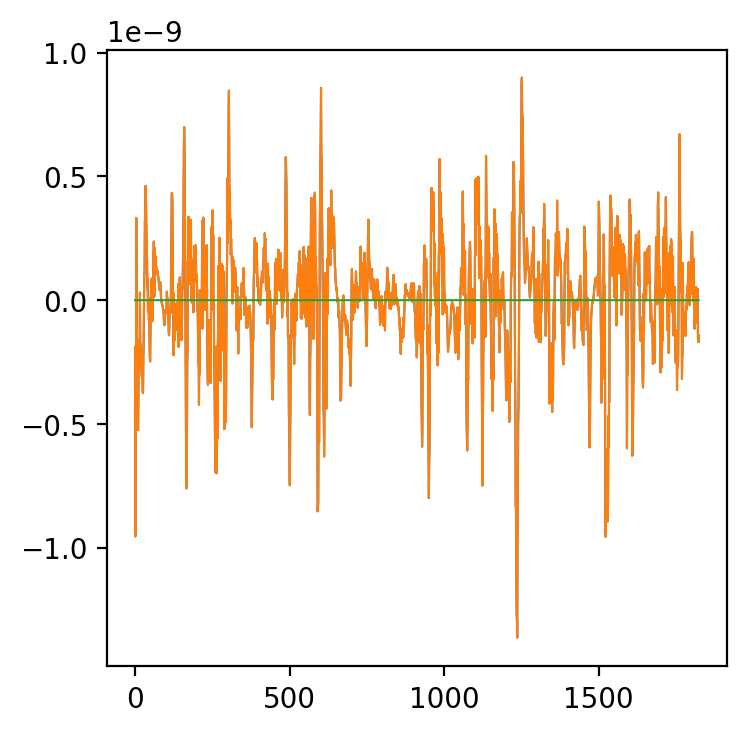

In [18]:
fluxes = hadv[1:,116,500] + vadv[1:,116,500] + diff[1:,116,500] + bio[1:,116,500]
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=200)
# plt.plot(hadv,linewidth=0.75)
# plt.plot(vadv,linewidth=0.75)
# plt.plot(diff,linewidth=0.75)
plt.plot(fluxes,linewidth=0.75)
plt.plot(tend[1:,116,500],linewidth=0.75)
plt.plot(fluxes -tend[1:,116,500],linewidth=0.75)

### O2 alignment with depth

In [5]:
h = static.depth_ocean.fillna(0)
nx = grid.derivative(grid.interp(h,['X']),'X')#.persist() # [m] 
ny = grid.derivative(grid.interp(h,['Y']),'Y')#.persist() # [m] 
nz = -xr.ones_like(h)
norm = np.sqrt(nx**2 + ny**2 + nz**2)#.persist()
nx = (nx/norm)#.persist()
ny = (ny/norm)#.persist()
nz = (nz/norm)#.persist()

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimensi

In [7]:
# ### measuring the normal o2 alignment
test = 1e6*dsnot.o2 # mumol/kg
o2_x = grid.derivative(grid.interp(test,['X']),'X') #convert to mumol then nondimensionalize distance using L=9250m [mumol]
o2_x_bound = o2_x.isel(zl=depth_ind) # select index before value so it doesn't go into land
o2_y = grid.derivative(grid.interp(test,['Y']),'Y') # convert to mumol then nondimensionalize distance using L=9250m [mumol]
o2_y_bound = o2_y.isel(zl=depth_ind) # select index before value so it doesn't go into land
o2_z = (test.differentiate('zl')) # to account for difference in depth levels, choose Z = 20 as nondim, xr.differentiate automatically accounts for difference in depth levles
o2_z_bound = o2_z.isel(zl=depth_ind)
divo2h_not = (o2_x_bound*nx + o2_y_bound*ny + o2_z_bound*nz).compute()

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimensi

In [14]:
### measuring the o2-h alignment
test = 1e6*dsnot.o2#.sel(time=slice('1997-02-01','1997-08-31'))#.mean('time') # mumol/m2/s
o2_x = grid.derivative(grid.interp(test,['X']),'X')*9250 #convert to mumol then nondimensionalize distance using L=9250m [mumol]
o2_x_bound = o2_x.isel(zl=depth_ind) # select index before value so it doesn't go into land
o2_y = grid.derivative(grid.interp(test,['Y']),'Y')*9250 # convert to mumol then nondimensionalize distance using L=9250m [mumol]
o2_y_bound = o2_y.isel(zl=depth_ind) # select index before value so it doesn't go into land
h_x = grid.interp(grid.derivative(static.depth_ocean,'X'),['X']) # use nondimensional distance
h_y = grid.interp(grid.derivative(static.depth_ocean,'Y'),['Y']) # use nondimensional distance
h_mag = np.sqrt(h_x**2 + h_y**2)
# o2_mag = np.sqrt(o2_x_bound**2 + o2_y_bound**2)
gradho2_not = ((o2_x_bound*h_x + o2_y_bound*h_y)/h_mag).compute()
# gradho2_not = gradho2_not[1:None,:,:] # first dimension from interpolation, spurious
# divo2h_norm = (o2_x_bound*h_x + o2_y_bound*h_y)/(h_mag*o2_mag)
# ang = 180+np.degrees(np.arctan2((o2_y_bound*h_y)/(h_mag*o2_mag),(o2_x_bound*h_x)/(h_mag*o2_mag)))
# intrusion = divo2h>0.005

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimensi

### Topostrophy

In [5]:
### making the depth index
depth_ind = np.abs(ds.zl- static.depth_ocean.fillna(0)).argmin(dim='zl').compute()
depth_ind = xr.where((static.depth_ocean>=ds.zl.isel(zl=depth_ind)),depth_ind,depth_ind-1)
depth_ind = depth_ind.where(np.isnan(static.depth_ocean)==0,0).astype('int').compute()

In [6]:
### topostrophy
h_x = grid.interp(grid.derivative(static.depth_ocean,'X'),['X']) # use nondimensional distance
h_y = grid.interp(grid.derivative(static.depth_ocean,'Y'),['Y']) # use nondimensional distance
# u_b = grid.interp(ds.u,'X').isel(zl=depth_ind.compute().persist()).mean('time').persist()
# v_b = grid.interp(ds.v,'Y').isel(zl=depth_ind.compute()).mean('time').persist()
u_b = (grid.interp(ds.u,'X')).isel(zl=depth_ind)
v_b = (grid.interp(ds.v,'Y')).isel(zl=depth_ind)
tau = (h_y*u_b - h_x*v_b).compute()
tau = tau[1:None,:,:] # first dimension from interpolation, spurious
tau.to_netcdf('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/ANALYSIS/bottom_topostrophy.nc')

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid.py:1645: UserWarning: Metric at ('yh', 'xq') being interpolated from metrics at dimensions ('yh', 'xh'). Boundary value set to 'extend'.
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_

In [7]:
### making the depth index
depth_ind = np.abs(ds.zl- static.depth_ocean.fillna(0)).argmin(dim='zl').compute()
depth_ind = xr.where((static.depth_ocean>=ds.zl.isel(zl=depth_ind)),depth_ind,depth_ind-1)
depth_ind = depth_ind.where(np.isnan(static.depth_ocean)==0,0).astype('int').compute()

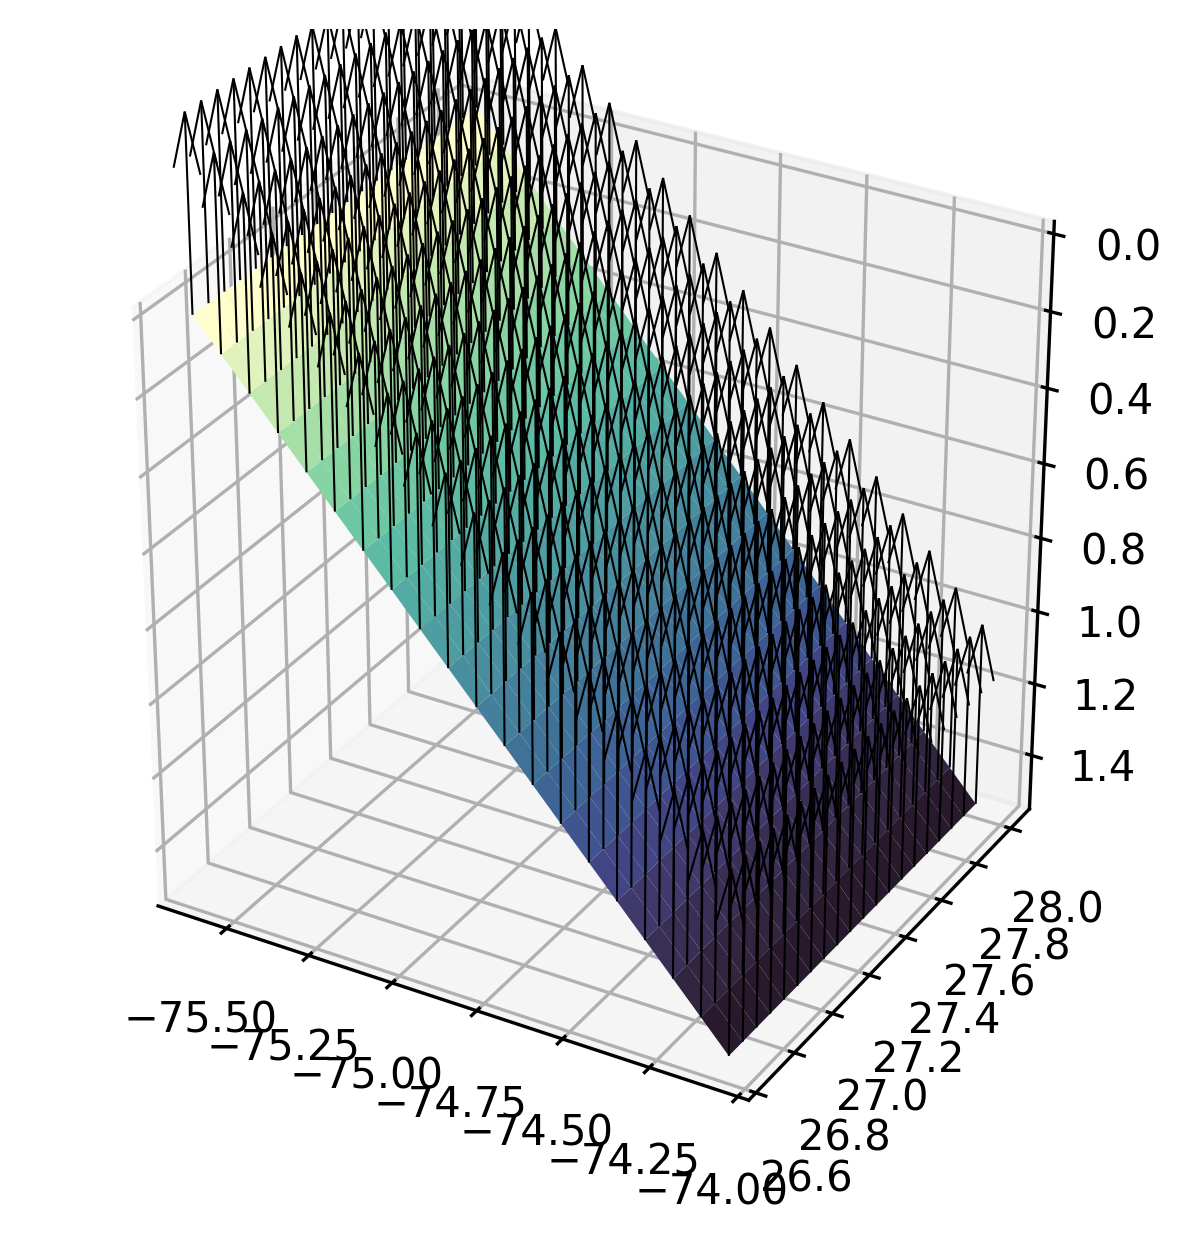

In [118]:
x,y,z = xr.broadcast(static.xh.isel(xh=slice(280,300)), static.yh.isel(yh=slice(280,300)),h) # xarray form of meshgrid
# 
ax = plt.figure(dpi=300).add_subplot(projection='3d')

ax.plot_surface(x, y, z,cmap='cmo.deep')
# ax.quiver(x,y,z, (nx/mag), (ny/mag), (nz/mag), length=0.1,linewidth=0.5,colors='black',normalize=True)
ax.quiver(x,y,z, nx/norm, ny/norm, nz/norm, length=0.5,linewidth=0.5,colors='black',normalize=True)
# ax.quiver(x.isel(xh=slice(254,257,yh=slice(280,284)).T,y.isel(xh=slice(250,254),yh=slice(280,284)).T,static.depth_ocean.fillna(0).isel(xh=slice(250,254),yh=slice(280,284)),x_norm.isel(xh=slice(250,254),yh=slice(280,284)),y_norm.isel(xh=slice(250,254),yh=slice(280,284)),z_norm.isel(xh=slice(250,254),yh=slice(280,284)),length=0.1,linewidths=0.5,normalize=True)
# ax.quiver(x.isel(xh=slice(250,270),yh=slice(280,300)).T,y.isel(xh=slice(250,270),yh=slice(280,300)).T,static.depth_ocean.fillna(0).isel(xh=slice(250,270),yh=slice(280,300)),x.isel(xh=slice(250,270),yh=slice(280,300)),y.isel(xh=slice(250,270),yh=slice(280,300)),static.depth_ocean.fillna(0).isel(xh=slice(250,270),yh=slice(280,300)),length=0.5,linewidths=0.5,normalize=True)
ax.invert_zaxis()
# ax.view_init(20, 90) # format: elevation_angle, horizontal angle
# cross = np.cross(h_x,h_y)
ax.set_box_aspect([
    float(x.max() - x.min()), 
    float(y.max() - y.min()), 
    float(z.max() - z.min())
])
plt.show()

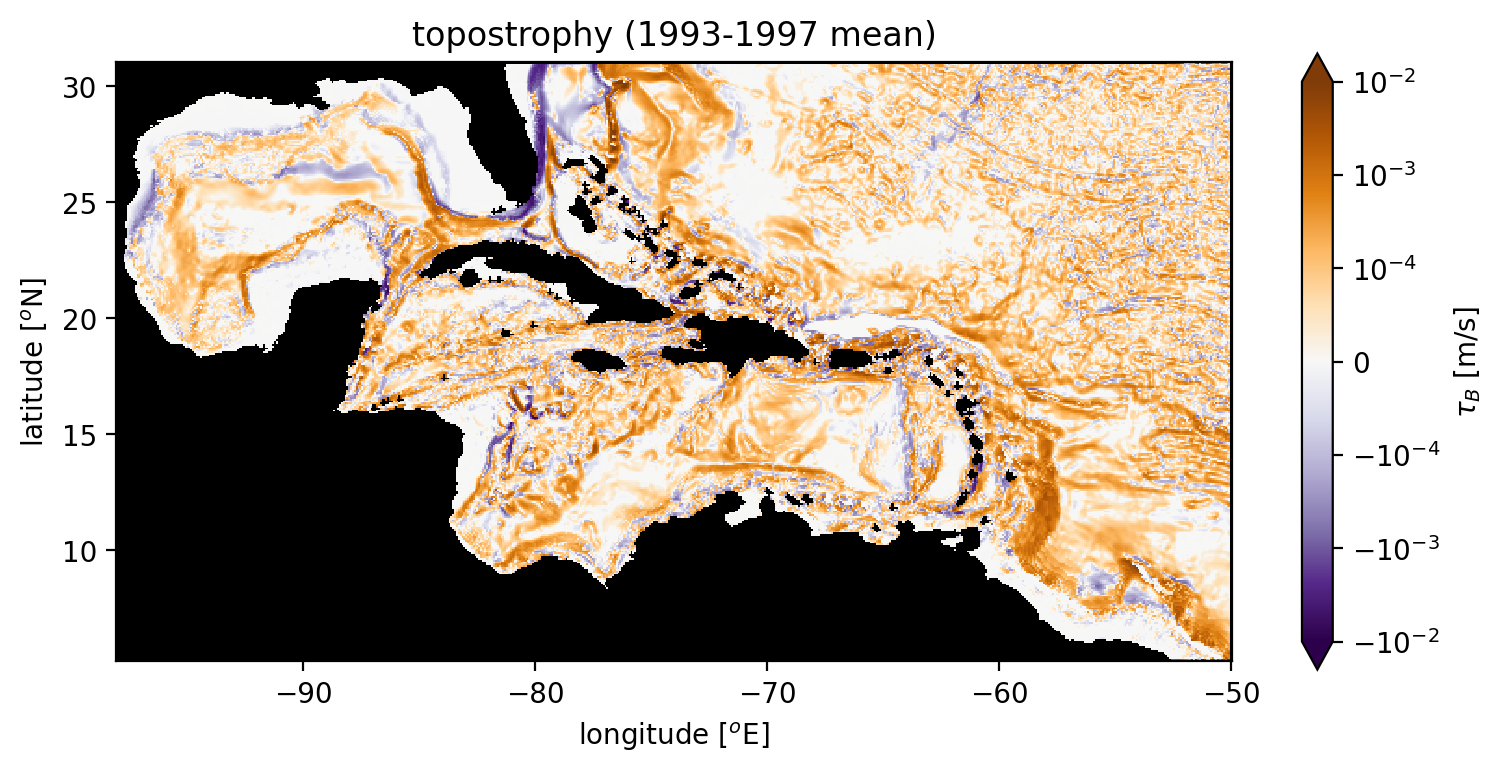

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9,4),dpi=200)
# nanmasked2 = plt.get_cmap('PuOr_r').copy()
# nanmasked2.set_bad('black')

# ### plot angles point in direction of increasing o2
# # intrusion.plot(x='xh',y='yh')
tau.mean('time').plot(x='xh',y='yh',norm=mpl.colors.SymLogNorm(linthresh=1e-5, linscale=1e-5,vmin=-1e-2, vmax=1e-2),cmap=nanmasked2,cbar_kwargs={'label':r'$\tau_B$ [m/s]','ticks':[-1e-2,-1e-3,-1e-4,0,1e-4,1e-3,1e-2]})#,vmin=0,vmax=0.015)
# CS = static.depth_ocean.plot.contour(x='xh',y='yh',levels=[500,1500,3000],colors='k', linewidths=0.25)
# ax.clabel(CS, fontsize=5)
ax.set_xlabel('longitude [$^o$E]')
ax.set_ylabel('latitude [$^o$N]')
ax.set_title('topostrophy (1993-1997 mean)')
# # ax.set_title(r'$\nabla_H$ NO$_3 \cdot \nabla_H$h/|$\nabla$h| [m/s]')
ax.set_aspect('equal')

In [ ]:
def make_hist(lat,lon,num):
    h = sns.jointplot(x=dsnow.thetao.isel(z_l=10).sel(xh=lon,yh=lat,method='nearest').values.ravel(), y=dspo2.po2.sel(xh=lon,yh=lat,method='nearest').values.ravel(), kind='hist',dropna=True,joint_kws={'bins':20,'cmap':'mako_r'},marginal_kws={'bins':20,'color':'mediumaquamarine'})

    if num<9:
        A0Bep = [21.617, 22.117, 18.702, 18.773, 22.595, 18.203, 21.026, 22.456]
        E0hat = [-0.13676, 0.055379, 0.37067, -0.21241, -0.25833, 0.036203, 0.077194, -0.11876]
        dE0dT = [0.14321, 0.17403, -0.040859, 0.028077, 0.059594, 0.099895, 0.11092, 0.16671]
        species = ['A. cervicornis','A. agaricites','A. tenuifolia','D. labyrinthiformis','M. cavernosa','O. faveolata','P. furcata','S. siderea']
        
        Xs = h.ax_marg_x.get_xlim()
        Ylims = h.ax_marg_y.get_ylim()
        Xs = np.linspace(Xs[0],Xs[1],50)
        test = (E0hat[num]+dE0dT[num]*(Xs-Tref))/kb
        po2_crit = 2.5/(A0Bep[num]*np.exp(test*(1/(273.15 + Xs)-1/(273.15 + Tref))))
        h.ax_joint.plot(Xs,po2_crit,linestyle='--',color='red')
        h.ax_marg_y.set_ylim(Ylims)

        h.fig.suptitle('('+str(np.round(dsnow.yh.sel(yh=lat,method='nearest').values,2))+'$\degree$N, '+str(np.round(dsnow.xh.sel(xh=lon,method='nearest').values,2))+'$\degree$E) at depth= '+str(dspo2.z_l.values)+' m for $\it{'+species[num]+'}$')

    else:
        h.fig.suptitle('('+str(np.round(dsnow.yh.sel(yh=lat,method='nearest').values,2))+'$\degree$N, '+str(np.round(dsnow.xh.sel(xh=lon,method='nearest').values,2))+'$\degree$E) at depth= '+str(dspo2.z_l.values)+' m')
        
    # JointGrid has a convenience function
    h.set_axis_labels('temperature [$\degree$C]','pO2 [atm]', fontsize=12)
    
    # # labels appear outside of plot area, so auto-adjust
    h.figure.tight_layout() 
    
    # # Extract the hexbin plot
    hb = h.ax_joint.collections[0]  # Hexbin object
    
    # # Create a colorbar on the new figure
    cbaxes = h.figure.add_axes([1.0, 0.1, 0.03, 0.8])  # This is the position for the colorbar
    cbar = plt.colorbar(hb, cax = cbaxes)
    cbar.set_label('# of months')
    
    h.fig.subplots_adjust(top=0.92)
    
    return h

# make_hist(28,-90,0)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3821262/3196448727.py:14: SyntaxWarning: invalid escape sequence '\d'
  h.set_axis_labels(r'o2 [$\mu$mol/kg]','temp [$\degree$C]',fontsize=10)
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 329.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 329.28 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
Se

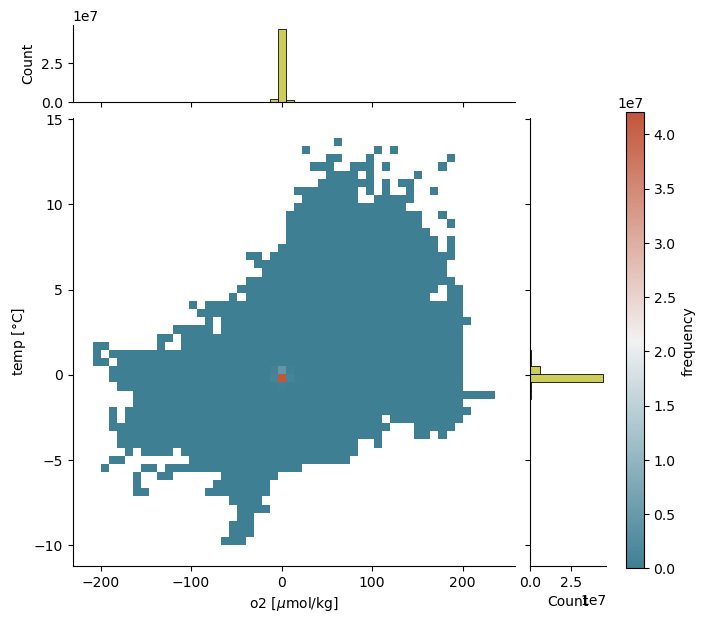

In [11]:
# seagreen = sns.light_palette("tab:olive", as_cmap=True)
seagreen = sns.diverging_palette(220, 20, as_cmap=True)
# from matplotlib.colors import LogNorm
btm_o2_diff = 1e6*(ds.o2.where(ds.o2>=0) - dsnot.o2.where(dsnot.o2>=0)).isel(zl=depth_ind).values.ravel()
btm_temp_diff = (ds.temp.where(ds.o2>=0) - dsnot.temp.where(dsnot.o2>=0)).isel(zl=depth_ind).values.ravel()
h = sns.jointplot(x=btm_o2_diff, y=btm_temp_diff, stat='count', dropna=True,kind='hist',joint_kws={'bins':50,'cmap':seagreen},marginal_kws={'bins':50,'color':'tab:olive'},marginal_ticks=True)
# h.ax_marg_x.set_xlim([0,250])
# h.ax_marg_x.set_yscale('log')
# h.ax_marg_y.set_xscale('log')
# h.ax_marg_y.set_ylim([0,6500])
# h.ax_marg_y.invert_yaxis()
# h.ax_joint.norm(LogNorm(vmin=1,vmax=1e7))
# h.set_axis_labels(r'$\nabla_{ND}$O$_2 \cdot \frac{\nabla H}{|\nabla H|}$ [$\mu$mol/kg]','depth [m]', fontsize=10)
h.set_axis_labels(r'o2 [$\mu$mol/kg]','temp [$\degree$C]',fontsize=10)
hb = h.ax_joint.collections[0]  # Hexbin object
cbaxes = h.figure.add_axes([1.0, 0.06, 0.03, 0.76])  # This is the position for the colorbar
cbar = plt.colorbar(hb, cax = cbaxes)
cbar.set_label('frequency')


KeyboardInterrupt



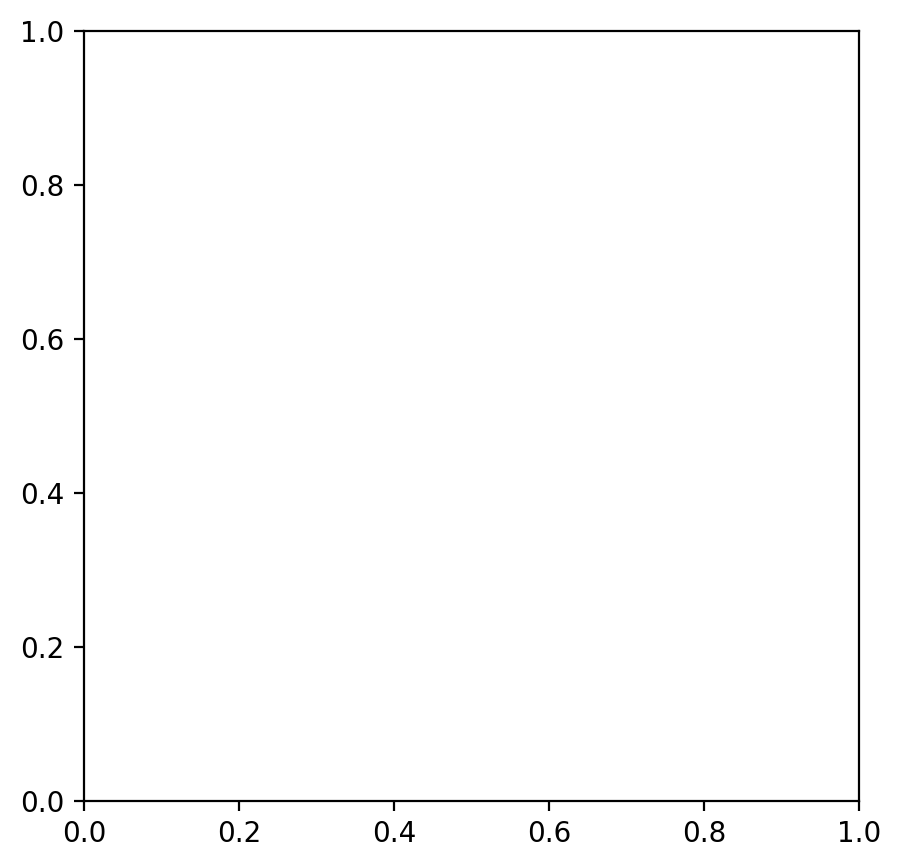

In [15]:
# from dask.diagnostics import ProgressBar
# with ProgressBar():

# divo2h_50 = divo2h.where(divo2h>=50).count(['xh','yh']).persist()
area_95 = ds.areacello.where(divo2h>=50).sum(['xh','yh']).persist() # area_97 is 1997, area_96 is 1996, etc.
# progress(divo2h_50)      # watch progress

fig, ax = plt.subplots(1, 1, figsize=(5,5),dpi=200)
# (100*divo2h_50/140617).plot(x='time') # percent of grid cells
(1e-6*area_95).plot(x='time') # area in km^2
# plt.ylabel('percentage of grid points [%]')
plt.ylim([350000,750000])
plt.ylabel('area [km$^2$]')
# plt.title(r'Grid points with $\nabla_{ND}$O$_2 \cdot \frac{\nabla H}{|\nabla H|}\geq$ 50 $\mu$mol/kg')
plt.title(r'Area with $\nabla_{ND}$O$_2 \cdot \frac{\nabla H}{|\nabla H|}\geq$ 50 $\mu$mol/kg')
# divo2h.isel(time=2).count().values # total number of points is 140617

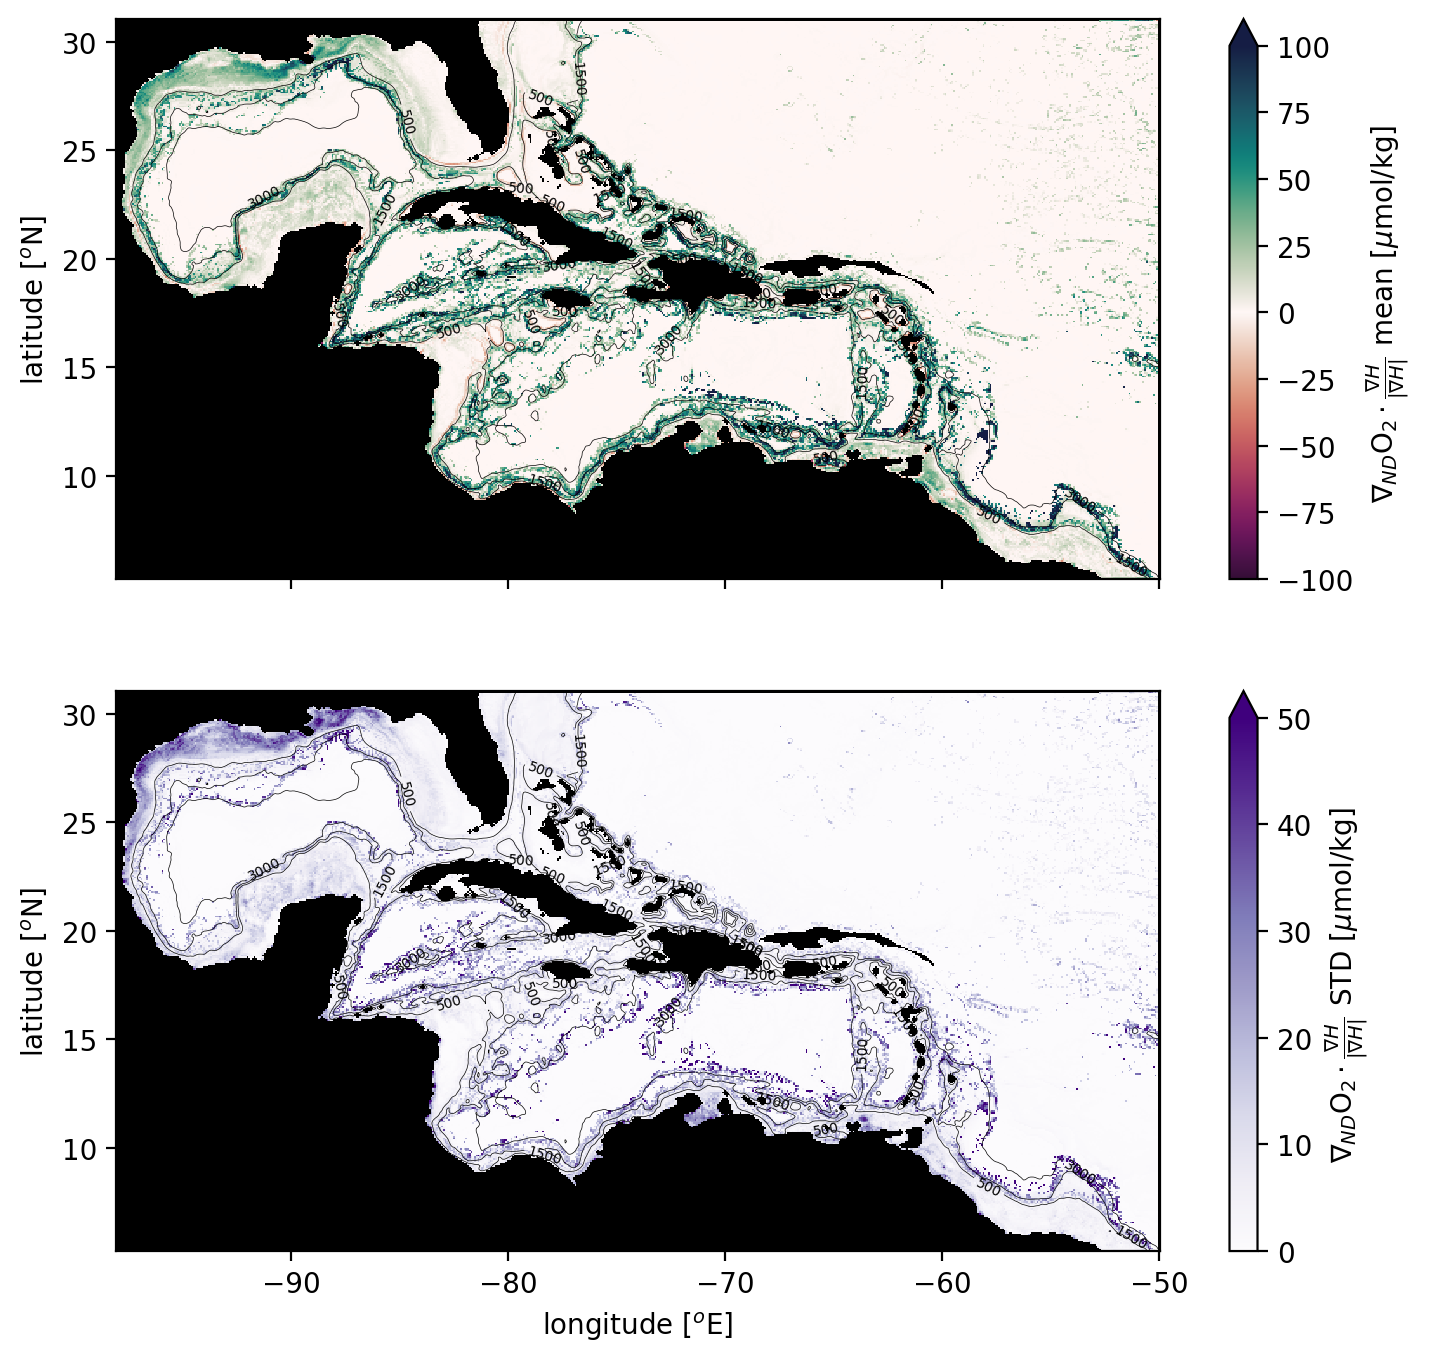

In [12]:
# divo2h_var = divo2h.var('time').persist()
# divo2h_mean = divo2h.mean('time').persist()
# divo2h_std = divo2h.std('time').persist()

fig, ax = plt.subplots(2, 1, figsize=(9,8),sharex=True,dpi=200)
nanmasked = plt.get_cmap('cmo.curl_r').copy()
nanmasked.set_bad('black')
divo2h_mean.plot(x='xh',y='yh',cmap=nanmasked,vmin=-100,vmax=100,ax=ax[0],cbar_kwargs={'label':r'$\nabla_{ND}$O$_2 \cdot \frac{\nabla H}{|\nabla H|}$ mean [$\mu$mol/kg]'}) 
nanmasked = plt.get_cmap('Purples').copy()
nanmasked.set_bad('black')
divo2h_std.plot(x='xh',y='yh',cmap=nanmasked,vmin=0,vmax=50,ax=ax[1],cbar_kwargs={'label':r'$\nabla_{ND}$O$_2 \cdot \frac{\nabla H}{|\nabla H|}$ STD [$\mu$mol/kg]'}) #.where(divo2h_mean>=0.005)
# # ds.wet.where(ds.wet==0).plot(x='xh',y='yh',cmap='berlin',add_colorbar=False)
# # divo2h_mean.plot.contour(x='xh',y='yh',levels=[0.005,0.01],linewidths=0.25,colors='white')
CS = static.depth_ocean.plot.contour(x='xh',y='yh',levels=[500,1500,3000],colors='k',ax=ax[0],linewidths=0.25)
ax[0].clabel(CS, fontsize=5)
CS = static.depth_ocean.plot.contour(x='xh',y='yh',levels=[500,1500,3000],colors='k',ax=ax[1],linewidths=0.25)
ax[1].clabel(CS, fontsize=5)
ax[1].set_xlabel('longitude [$^o$E]')
ax[0].set_xlabel('')
ax[0].set_ylabel('latitude [$^o$N]')
ax[1].set_ylabel('latitude [$^o$N]')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

### Fourier analysis

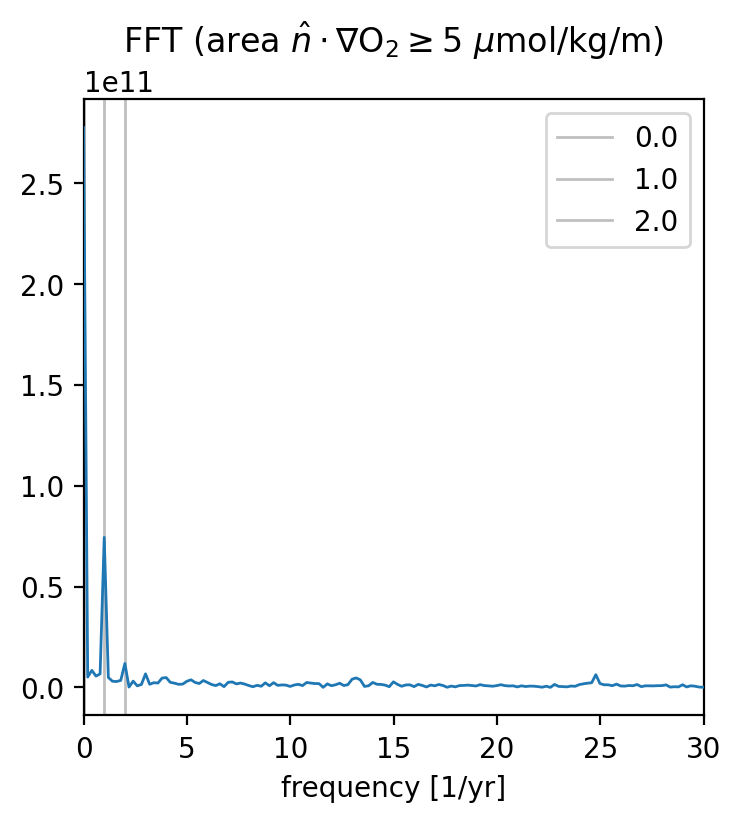

In [5]:
# lon = np.abs(ds.xh- -58).argmin().values
# lat = np.abs(ds.yh- 8).argmin().values
# depth = np.abs(ds.zl- static.depth_ocean.isel(xh=lon,yh=lat)).argmin().values

# test = ds.o2.isel(xh=lon,yh=lat,zl=depth) - ds.o2.isel(xh=lon,yh=lat,zl=depth).mean('time')
# ## Number of sample points
areas = static.areacello.where(divo2h.divo2h>=5).sum(['xh','yh']).persist()
N = areas.shape[0]
# # ## sample spacing
T = 1.0#/24/60/60 800.0
# # # x = np.linspace(0.0, N*T, N, endpoint=False)
# # # y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(areas)
xf = fftfreq(N, T)[:N//2]
fig, ax = plt.subplots(1, 1, figsize=(4,4),dpi=200)
big = (2.0/N * np.abs(yf[0:N//2])).argsort()[-4:][::-1] # find index of top 4 values
plt.axvline(xf[big[0]]*365,c='gray',linewidth=1,alpha=0.5)
plt.axvline(xf[big[1]]*365,c='gray',linewidth=1,alpha=0.5)
plt.axvline(xf[big[2]]*365,c='gray',linewidth=1,alpha=0.5)
# plt.axvline(xf[big[3]]*365,c='gray',linewidth=1,alpha=0.5)
plt.legend(np.round([xf[big[0]]*365,xf[big[1]]*365,xf[big[2]]*365,xf[big[3]]*365],2))
plt.plot(xf*365, 2.0/N * np.abs(yf[0:N//2]),linewidth=1,zorder=5) # frequency in units of 1/day*365days/yr
plt.xlabel('frequency [1/yr]')
plt.title(r'FFT (area $\hat{n}\cdot\nabla$O$_2 \geq$5 $\mu$mol/kg/m)')
plt.xlim([0,30])
# plt.ylim([0,2e11])
# plt.grid()
# ax.set_xscale('log')
plt.show()

In [6]:
# (2.0/N * np.abs(yf[0:N//2])).argsort()[-4:][::-1]
# ffto2 = 2.0/N * np.abs(yf[0:N//2])
# xf[big[2]]*365

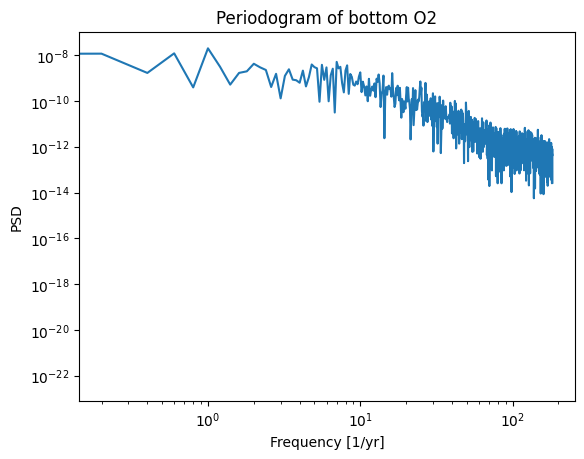

In [36]:
# from scipy.signal import periodogram

# Generating a sample signal (bird chirp)
# duration = 2  # seconds
# fs = 8000  # Sampling frequency (Hz)
# t = np.linspace(0, N*T, N, endpoint=False)
# signal = np.sin(2 * np.pi * 1000 * np.sqrt(t))  # Frequency increases over time

# Calculating the periodogram
# frequencies, powers = periodogram(test, 1)

# Plotting the periodogram
plt.loglog(frequencies*365, powers)
plt.title('Periodogram of bottom O2')
plt.xlabel('Frequency [1/yr]')
plt.ylabel('PSD')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)
static.wet.plot(x='xh',y='yh',cmap='binary',add_colorbar=False)
low = ds.btm_o2.isel(time=0).where(ds.btm_o2.isel(time=0)<1.5e-4).plot(x='xh',y='yh',vmin=0,vmax=1.5e-4,cmap='cmo.haline')
ax.set_aspect('equal')
ax.set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values)

# def animate(frame):
#     low.set_array(ds.btm_o2.isel(time=30*frame).where(ds.btm_o2.isel(time=30*frame)<1.5e-4))
#     ax.set_title(label='Date: ' + ds.time[30*frame].dt.strftime('%Y-%m-%d').values)
#     plt.tight_layout()
                   
# ani = animation.FuncAnimation(fig, animate, frames=329)
# ani.save('/scratch/gpfs/CDEUTSCH/wchu/images/btmo2_150orless.gif', writer='imagemagick', fps = 10) #Save animation as gif-file

# HTML(ani.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.


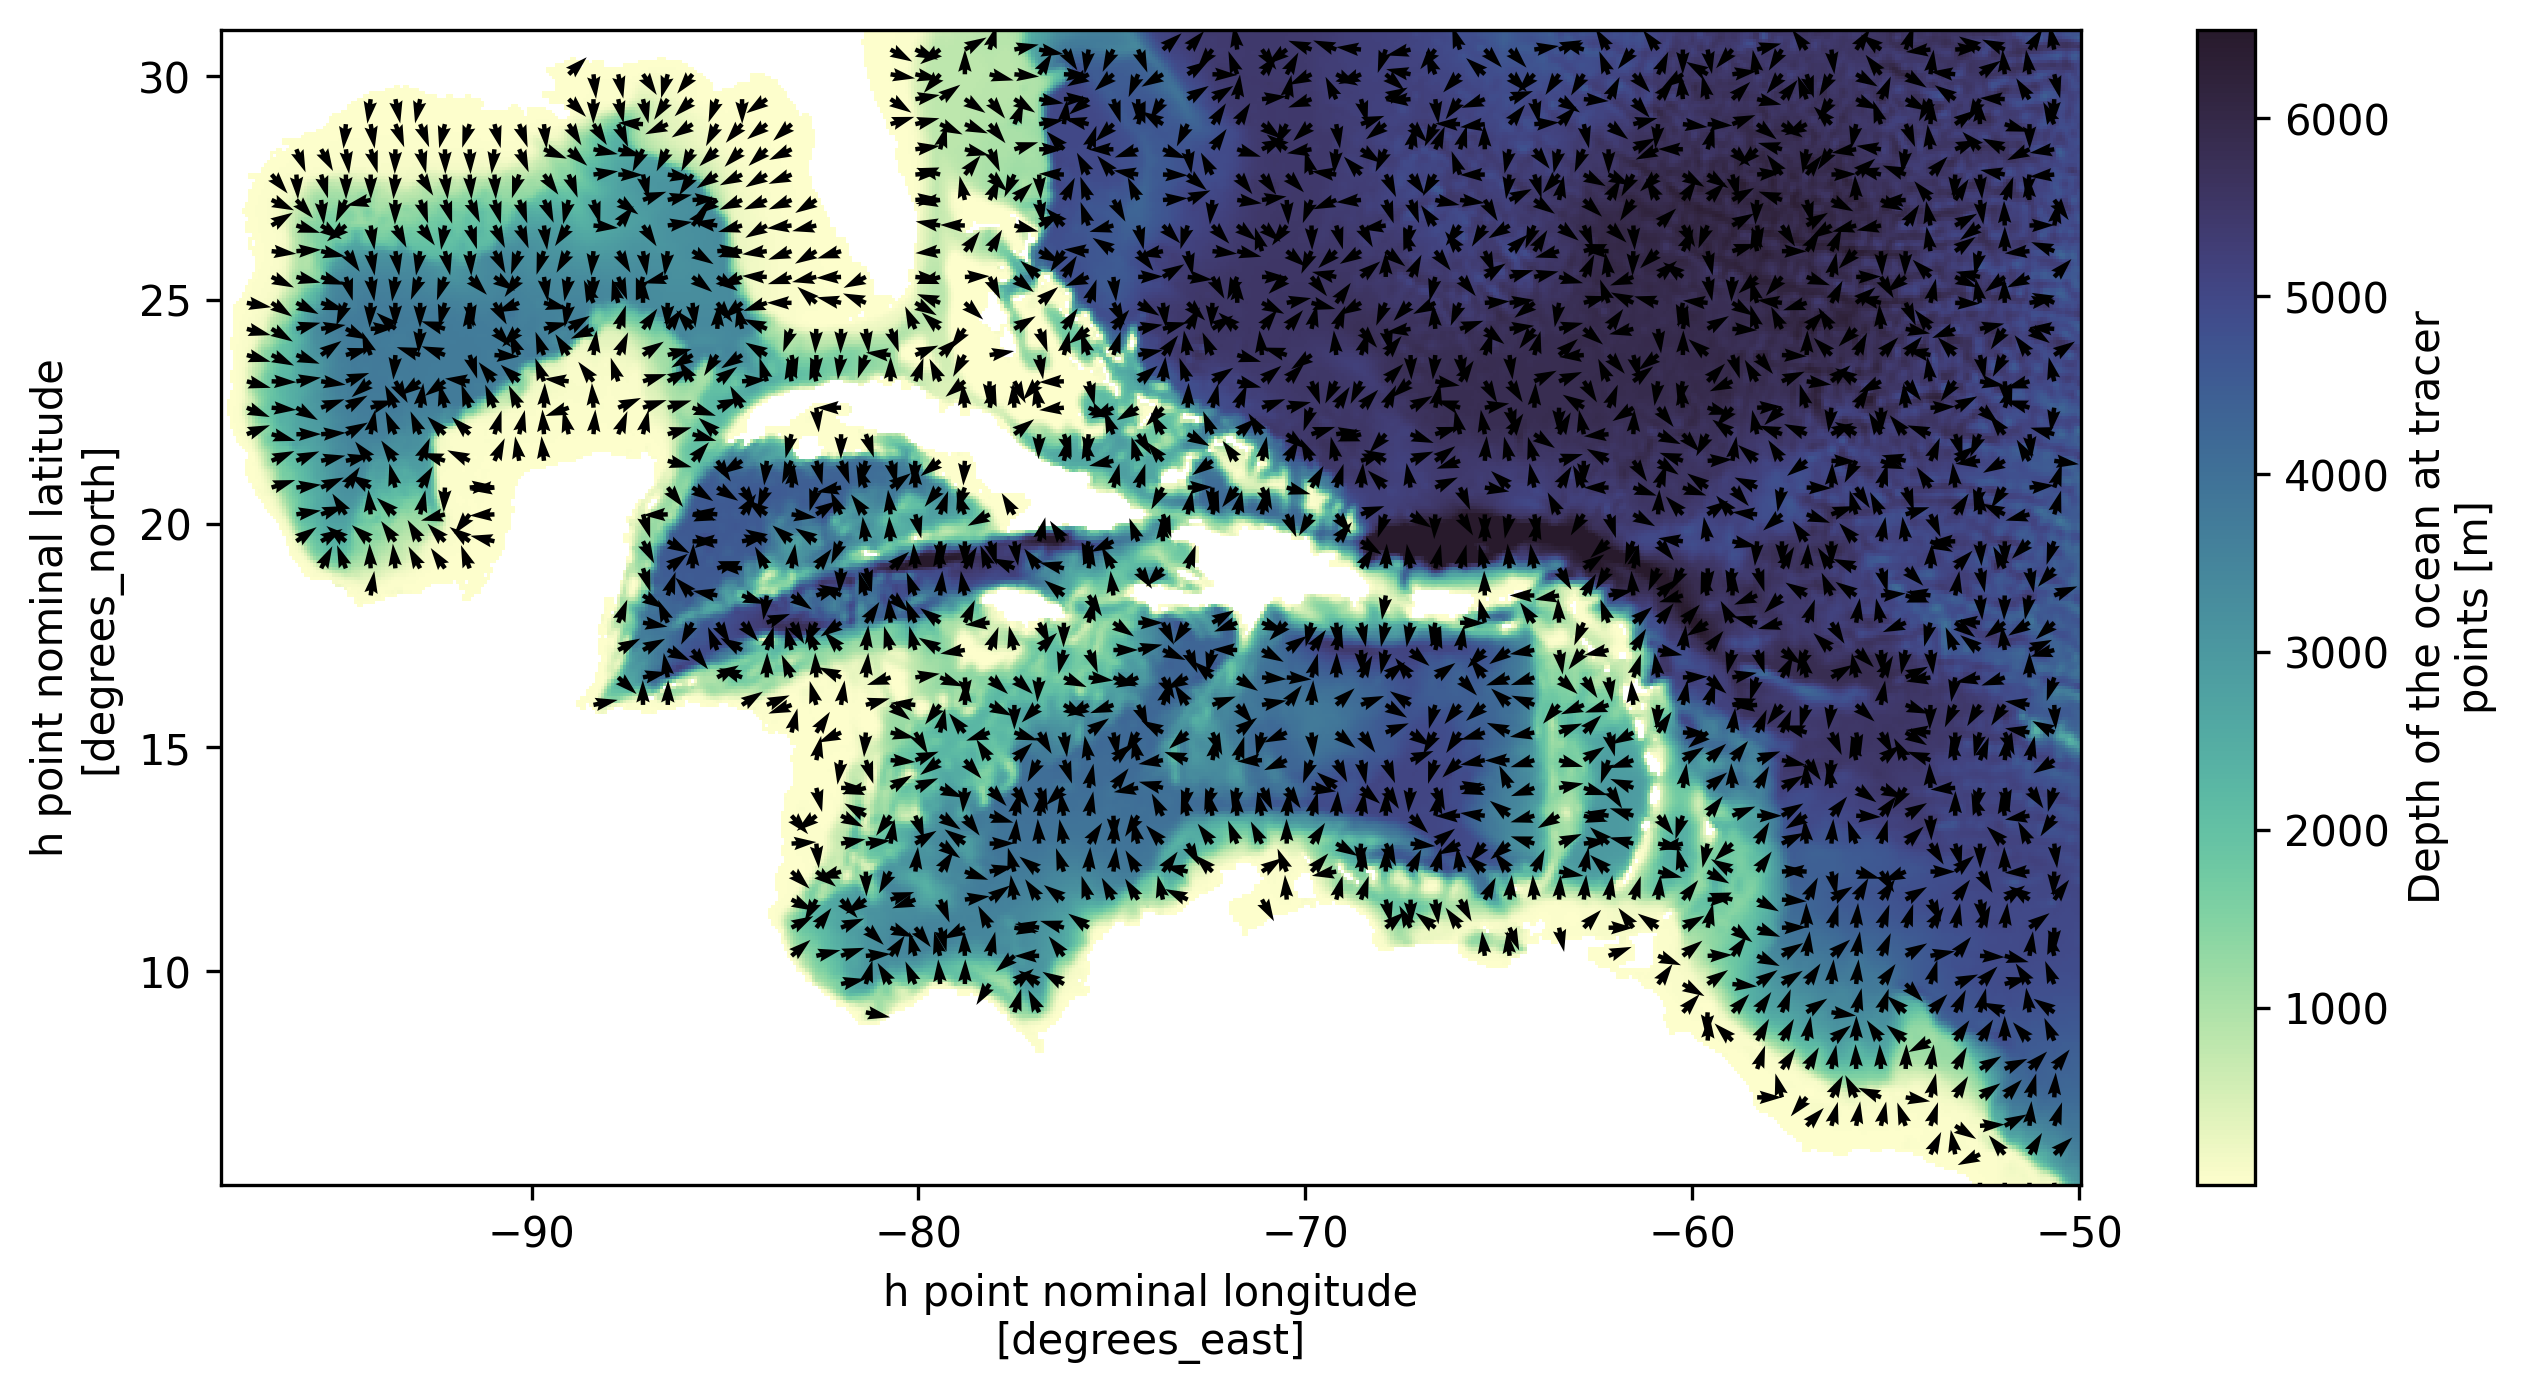

In [29]:
# test = grid.interp(1e6*ds.o2min.sel(z_l=1000,method='nearest').mean('time'),['X','Y'])
# o2_x = grid.derivative(test.where(static.depth_ocean),'X') # convert to mumol so [mumol/m]
# o2_y = grid.derivative(test.where(static.depth_ocean),'Y') # convert to mumol so [mumol/m]
# # color = test.isel(xh=slice(0,602,2),yh=slice(0,343,2))

# # o2dotn = land_x.values*o2_x.values + land_y.values*o2_y.values
# # o2dotn.shape
# # norm = mpl.colors.Normalize(-0.005,0.005)
# # cm = cmocean.cm.haline
# ## color = np.sqrt(o2_x.isel(zl=0).values**2 + o2_y.isel(zl=0).values**2)
# # nanmasked = plt.get_cmap('binary').copy()
# # nanmasked.set_bad('black')

# fig, ax = plt.subplots(1, 1, figsize=(7,4), dpi=300)
# plt.pcolormesh(static.xh,static.yh,test.where(np.isnan(test),1),cmap=nanmasked)
# quiver = ax.quiver(ds.xh,ds.yh, o2_x, o2_y, o2dotn,cmap='cmo.balance',scale=0.1,norm=norm,units='width',angles='xy') #cm(norm(o2_y.isel(zl=0)))
# plt.colorbar(quiver)

fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi=300)
# # plt.pcolormesh(static.xh,static.yh,test.where(np.isnan(test),1),cmap=nanmasked)
static.depth_ocean.plot(x='xh',y='yh',cmap='cmo.deep')
quiver = ax.quiver(ds.xh.isel(xh=slice(0,602,8)),ds.yh.isel(yh=slice(0,344,8)), (h_x/h_mag).isel(xh=slice(0,602,8),yh=slice(0,344,8)), (h_y/h_mag).isel(xh=slice(0,602,8),yh=slice(0,344,8)),linewidths=0.01,cmap='cmo.balance',scale=75,units='width',angles='xy') #cm(norm(o2_y.isel(zl=0)))
# # plt.colorbar(quiver)


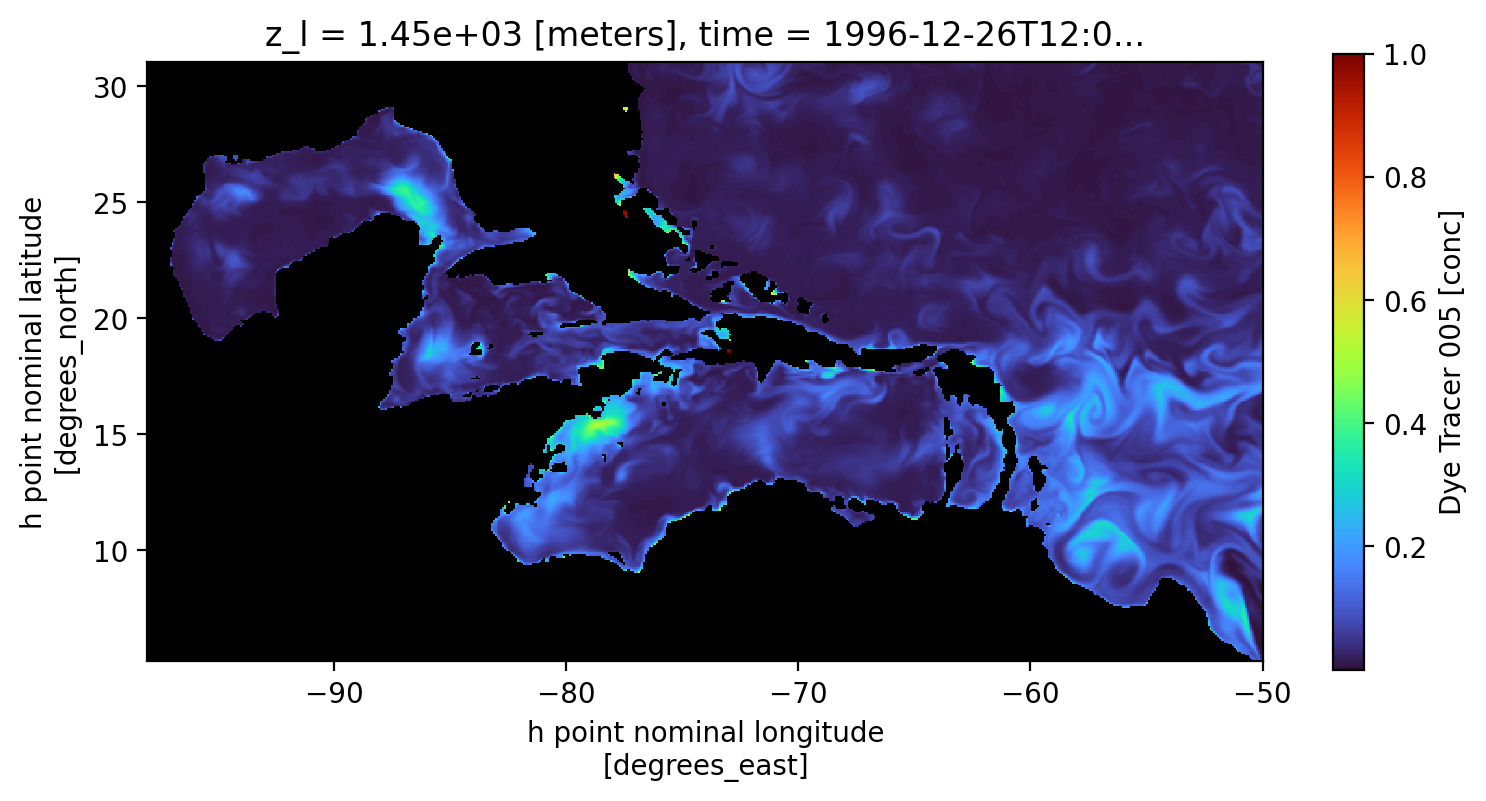

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)
ds.dye800m.isel(time=1455).sel(z_l=1400,method='nearest').plot(x='xh',y='yh',cmap=nanmasked)#,add_colorbar=False)
# test = ds.Rho_cv.isel(time=1300).sel(z_l=2750,method='nearest')# - ds.Rho_cv.isel(time=1500).sel(z_l=2750,method='nearest').mean(['xh','yh'])
# test.plot(x='xh',y='yh',cmap=nanmasked)#,add_colorbar=False)
ax.set_aspect('equal')

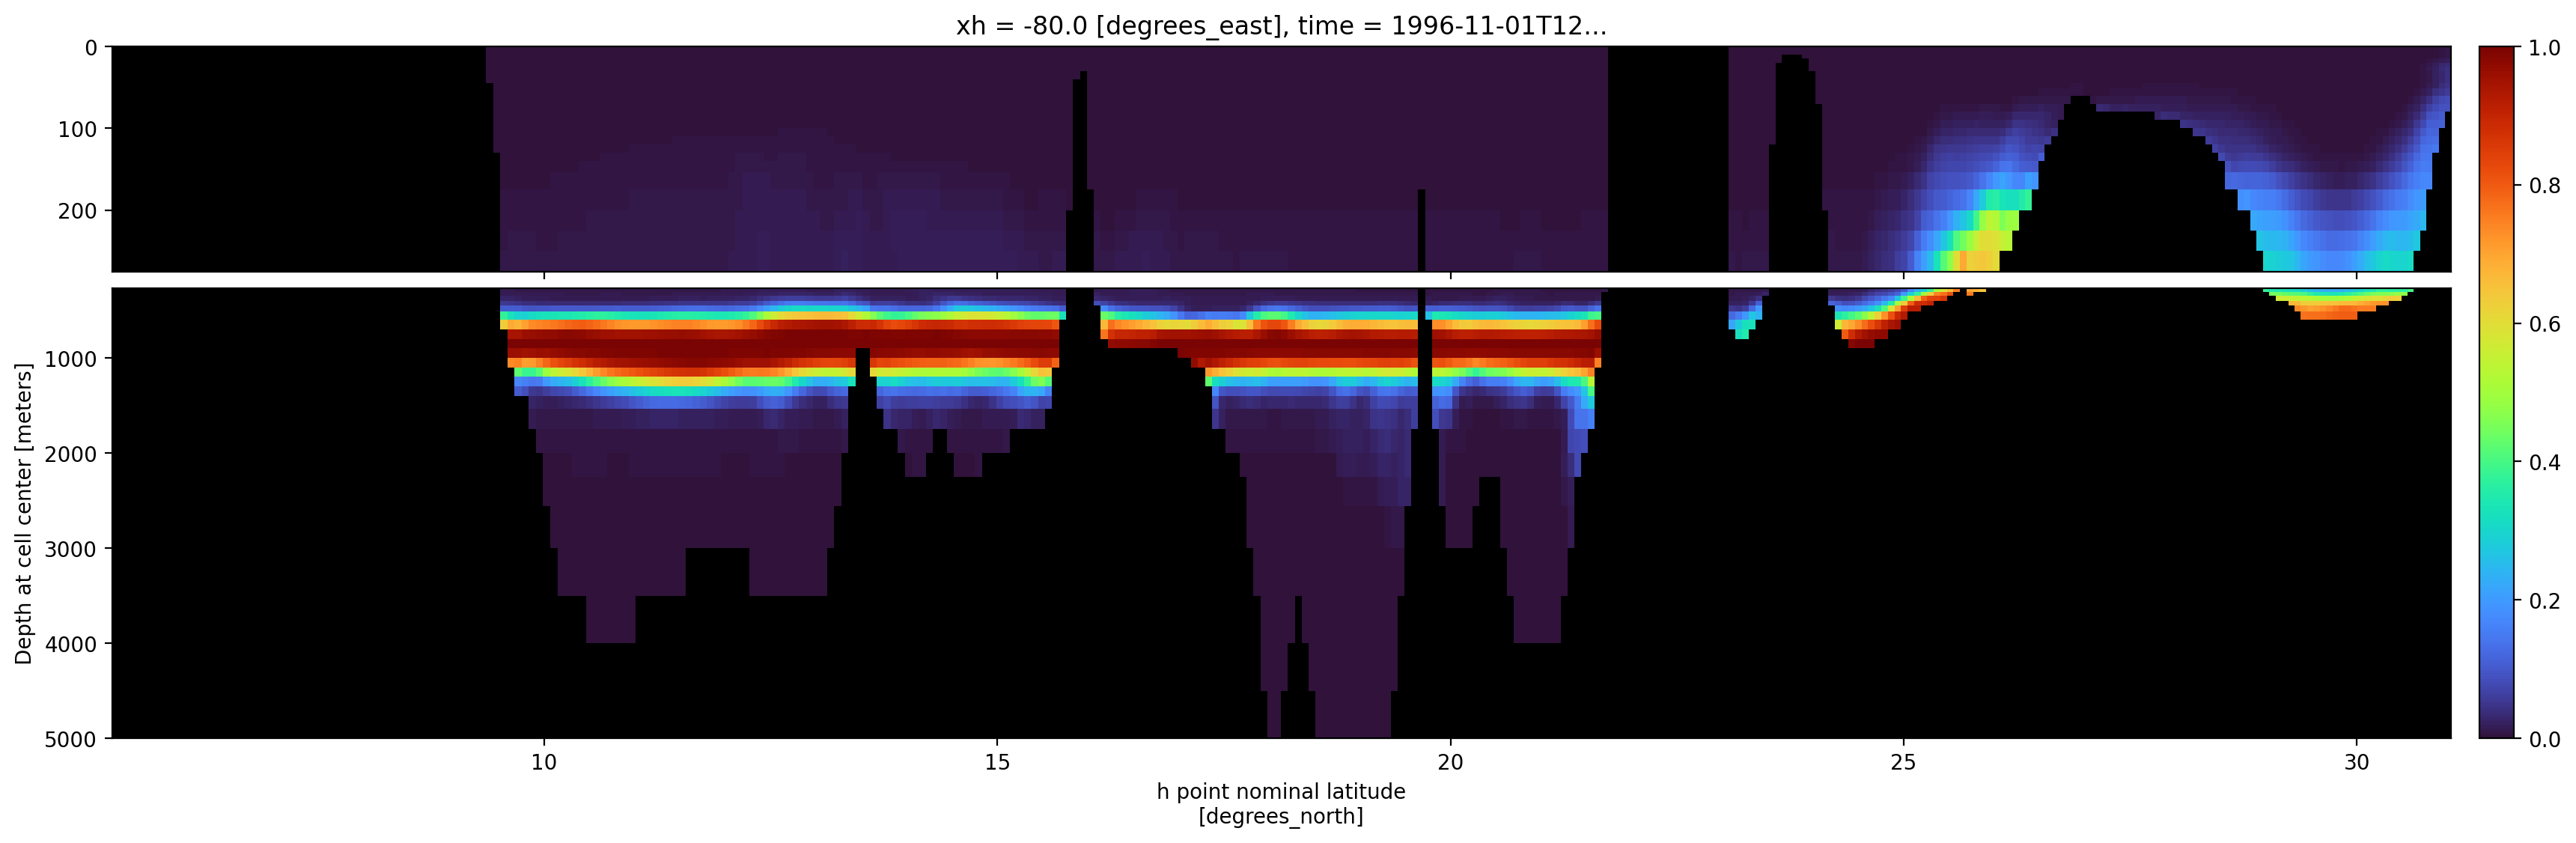

In [7]:
### tracer

fig, ax = plt.subplots(2, 1, figsize=(24,6),height_ratios=[1, 2],sharex=True,dpi=200)
# time_ind = 120
top=ds.dye800m.isel(z_l=slice(0,25),time=1400).sel(xh=-80,method='nearest').plot(x='yh',y='z_l',yincrease=False,vmin=0,vmax=1,cmap=nanmasked,add_colorbar=False,ax=ax[0]) # deriv lands back on xh 
# static.wet_depth.where(static.wet_depth==0).isel(xh=300,yh=slice(135,None),z_l=slice(0,34)).plot(x='yh',y='z_l',yincrease=False,cmap='binary',add_colorbar=False,ax=ax[0]) # deriv lands back on xh 
im=ds.dye800m.isel(z_l=slice(25,49),time=1400).sel(xh=-80,method='nearest').plot(x='yh',y='z_l',yincrease=False,vmin=0,vmax=1,cmap=nanmasked,add_colorbar=False,ax=ax[1]) # deriv lands back on xh 
# static.wet_depth.where(static.wet_depth==0).isel(xh=300,yh=slice(135,None),z_l=slice(34,50)).plot(x='yh',y='z_l',yincrease=False,cmap='binary',add_colorbar=False,ax=ax[1]) 
ax[1].set_title('')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
fig.subplots_adjust(hspace=0.05)
fig.colorbar(im, ax=ax.ravel().tolist(),pad=0.01)
# # ax.fill_between(ds.yh,static.depth_ocean.fillna(0.).isel(xh=50),7000*np.ones(343),color='black') # fake topography since we're in native coordinates
# ax[0].set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values + '  Longitude: {:0.2f}'.format(ds.xh[520].values) + '$^{\circ}$E')
plt.show()

# def animate(frame):
#     top.set_array(ds.v.isel(yq=322,time=frame,z_l=slice(0,25),xh=slice(200,None)))
#     im.set_array(ds.v.isel(yq=322,time=frame,z_l=slice(25,45),xh=slice(200,None)))
#     ax[0].set_title(label='Date: ' + ds.time[frame].dt.strftime('%Y-%m-%d').values + '  Latitude: {:0.2f}'.format(ds.yq[322].values) + '$^{\circ}$N')
#     plt.tight_layout()
                   
# ani = animation.FuncAnimation(fig, animate, frames=364)
# ani.save('/scratch/gpfs/CDEUTSCH/wchu/images/v_30N.gif', writer='imagemagick', fps = 20) #Save animation as gif-file

# HTML(ani.to_jshtml())

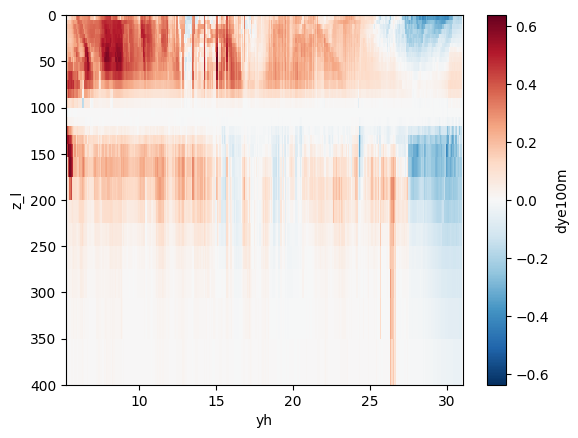

In [54]:
# time_ind=30
nobound = grid.average(ds.dye100m.where(static.boundary_mask==0).mean('time'),'X')
bound = grid.average(ds.dye100m.where(static.boundary_mask).mean('time'),'X')
# bound.plot(y='z_l',yincrease=False)
# nobound.plot(y='z_l',yincrease=False)
diff = bound - nobound
diff.sel(**{'z_l':slice(0,400)}).plot(x='yh',y='z_l',yincrease=False) #.sel(**{'z_l':slice(0,1200)})
# plt.legend(['boundary','not boundary','boundary - not'])

# nobound = grid.average(ds.dye400m.where(static.boundary_mask==0).sel(xh=-73,method='nearest').mean('time'),'Y').sel(xh=-73,method='nearest')
# bound = grid.average(ds.dye400m.where(static.boundary_mask).sel(xh=-73,method='nearest').mean('time'),'Y').sel(xh=-73,method='nearest')
# bound.plot(y='z_l',yincrease=False)
# nobound.plot(y='z_l',yincrease=False)
# diff = bound - nobound
# diff.plot(y='z_l',yincrease=False)
# plt.legend(['boundary','not boundary','boundary - not'])

/tmp/ipykernel_1505548/3511329371.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/frequency_axis/60/60/24/365, norm_amplitude)


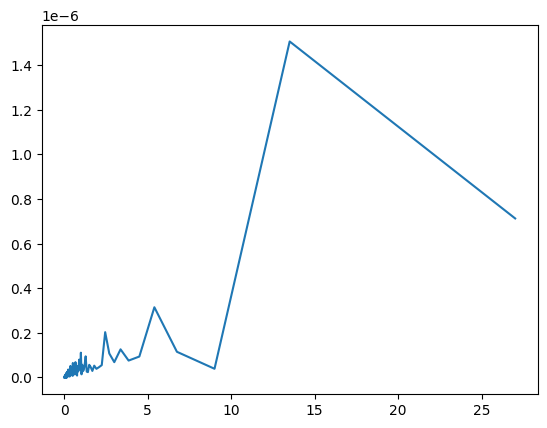

In [43]:
# from scipy.fft import fft, rfft
# from scipy.fft import fftfreq, rfftfreq

o2_test = grid.average(ds.btm_o2.where((static.depth_ocean<700) & (static.depth_ocean>300)),['X','Y'])
fo2_test = rfft(o2_test)

N = len(o2_test)
normalize = N/2

sampling_rate = 1/60/60/24 # once per day [1/sec]
frequency_axis = rfftfreq(N, d=1.0/sampling_rate)
norm_amplitude = np.abs(fo2_test)/normalize

# Plot the results
plt.plot(1/frequency_axis/60/60/24/365, norm_amplitude)
# plt.xlim([0,3])

In [37]:
# o2_test = grid.average(dsnow.btm_o2,['X','Y'])
# f_test = [grid.average(ds.o2.where(static.wet_depth).sel(zl=x,method='nearest'), ['X','Y']) for x in np.arange(0,2100,100)]
# r = np.corrcoef(o2_test, f_test)
r = [np.corrcoef(o2_test, grid.average(ds.o2.where(static.wet_depth).sel(zl=depth,method='nearest'), ['X','Y']))[0,1] for depth in np.arange(0,2100,100)]
# data_path = '/scratch/gpfs/CDEUTSCH/wchu/may_data/nwa12_o2b.nc'
# dsnow = xr.open_dataset(data_path,chunks='auto')
# dsnow = dsnow.isel(xh=slice(0,601),yh=slice(0,343),time=slice(0,365))
plt.scatter(r,np.arange(0,2100,100))
plt.xlabel('correlation coefficient (r)')
plt.ylabel('depth')
plt.gca().invert_yaxis()

In [19]:
# data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/INPUT/glofas_runoff_1994.nc'
# dsnow = xr.open_dataset(data_path,chunks='auto')

# dsnow["runoff"] = 0*dsnow["runoff"]

# dsnow_norunoff = xr.zeros_like(dsnow)
# dsnow_norunoff
# nanmasked2 = plt.get_cmap('cmo.haline').copy()
# nanmasked2.set_bad('white')
# dsnow.runoff.where(dsnow.runoff!=0).isel(time=0).plot(x='x',y='y',cmap=nanmasked2)
# dsnow_norunoff.runoff.isel(time=0).plot(x='x',y='y')
# dsnow_norunoff.runoff.where(dsnow_norunoff.runoff!=0).isel(time=20,x=slice(0,601),y=slice(0,343)).plot(x='x',y='y',cmap=nanmasked2)
dsnow.to_netcdf('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/INPUT/MULTIYEAR-GLOFAS/glofas_NOrunoff_1994.nc')

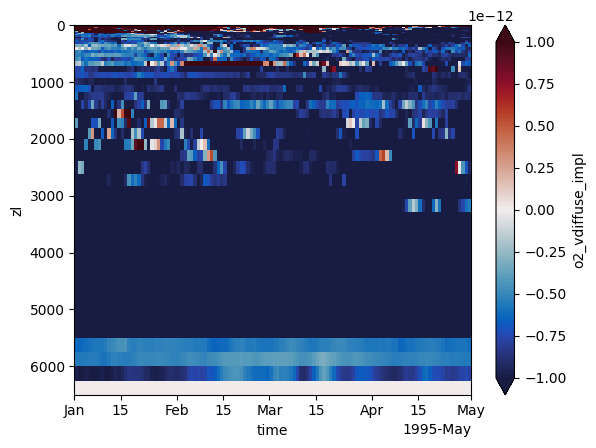

In [4]:
# ### tracer
# fig, ax = plt.subplots(2, 1, figsize=(24,6),height_ratios=[1, 3],sharex=True,dpi=200)
# test = ds.KHTR_h.isel(time=0).sel(xh=-86,method='nearest').sel(**{'yh': slice(21,24)})
# test.isel(zi=slice(0,35)).plot(x='yh',y='zi',yincrease=False,cmap=nanmasked,add_colorbar=False,ax=ax[0]) # deriv lands back on xh ,vmin=1.5e-4, vmax=2.7e-4
# im=test.isel(zi=slice(35,56)).plot(x='yh',y='zi',yincrease=False,cmap=nanmasked,add_colorbar=False,ax=ax[1]) # deriv lands back on xh 
# ax[1].set_title('')
# ax[0].set_xlabel('')
# ax[0].set_ylabel('')
# fig.subplots_adjust(hspace=0.05)
# fig.colorbar(im, ax=ax.ravel().tolist(),pad=0.01)
# # # ax.fill_between(ds.yh,static.depth_ocean.fillna(0.).isel(xh=50),7000*np.ones(343),color='black') # fake topography since we're in native coordinates
# # # ax.set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values + '  Latitude: {:0.2f}'.format(ds.yh[200].values) + '$^{\circ}$N')
# # plt.show()
# fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)

boundary_Kd = grid.average(ds.o2_vdiffuse_impl.where(static.boundary_mask),['X','Y'])#.sel(**{'zl':slice(1000,7000)}).mean('zi')
all_Kd = grid.average(ds.o2_vdiffuse_impl.where(static.wet_depth),['X','Y'])#.sel(**{'zl':slice(1000,7000)}).mean('zi') #.sel(**{'zi':slice(500,1000)})
# all_Kd.plot(x='time',y='zl')
diff = boundary_Kd - all_Kd
diff.plot(x='time',y='zl',cmap='cmo.balance',yincrease=False,vmin=-1e-12,vmax=1e-12)
# plt.legend(['boundary','all'])

# ds.o2_diffusion_xy.where(static.boundary_mask).isel(zl=30,time=0).plot(x='xh',y='yh',cmap=nanmasked2)
# ax.set_aspect('equal')
# static.wet_depth_zi.where(static.wet_depth_zi==0).isel(zi=30).plot(x='xh',y='yh',cmap='cmo.balance')

In [7]:
### contributions of various budget terms
# terms = {}
# terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

# fluxes = ds.o2_advection_xy + ds.o2h_tendency_vert_remap + ds.o2_diffusion_xy + ds.o2_vdiffuse_impl + ds.jo2/1035 
# residual = ds.o2h_tendency - fluxes

# advection_norm = (ds.o2_advection_xy + ds.o2h_tendency_vert_remap)/fluxes
# vdiffuse_norm = ds.o2_vdiffuse_impl/fluxes
# jo2_norm = ds.jo2/1035/fluxes
# fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=200)
# jo2_norm.where(ds.h==0).isel(time=30).sel(zl=700,method='nearest').plot(x='xh',y='yh',vmin=-1,vmax=1,cmap=nanmasked)
# ax.set_aspect('equal')
# ds.o2.where(static.boundary_mask).isel(time=0,z_l=20).plot(x='xh',y='yh',cmap=nanmasked)

# ds.o2.where(static.boundary_mask).isel(time=0,z_l=0).plot(x='xh',y='yh')

# divo2 = grid.interp(grid.derivative(ds.o2.mean('time'),'X'),'X') + grid.interp(grid.derivative(ds.o2.mean('time'),'Y'),'Y')

umag = np.sqrt(grid.interp(ds.u.mean('time')**2,'X') + grid.interp(ds.v.mean('time')**2,'Y'))
## divergence
# divo22 = (grid.interp(grid.diff(ds.o2.isel(time=0)*static.dxt,'X'),'X') + grid.interp(grid.diff(ds.o2.isel(time=0)*static.dyt,'Y'),'Y'))/static.areacello

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


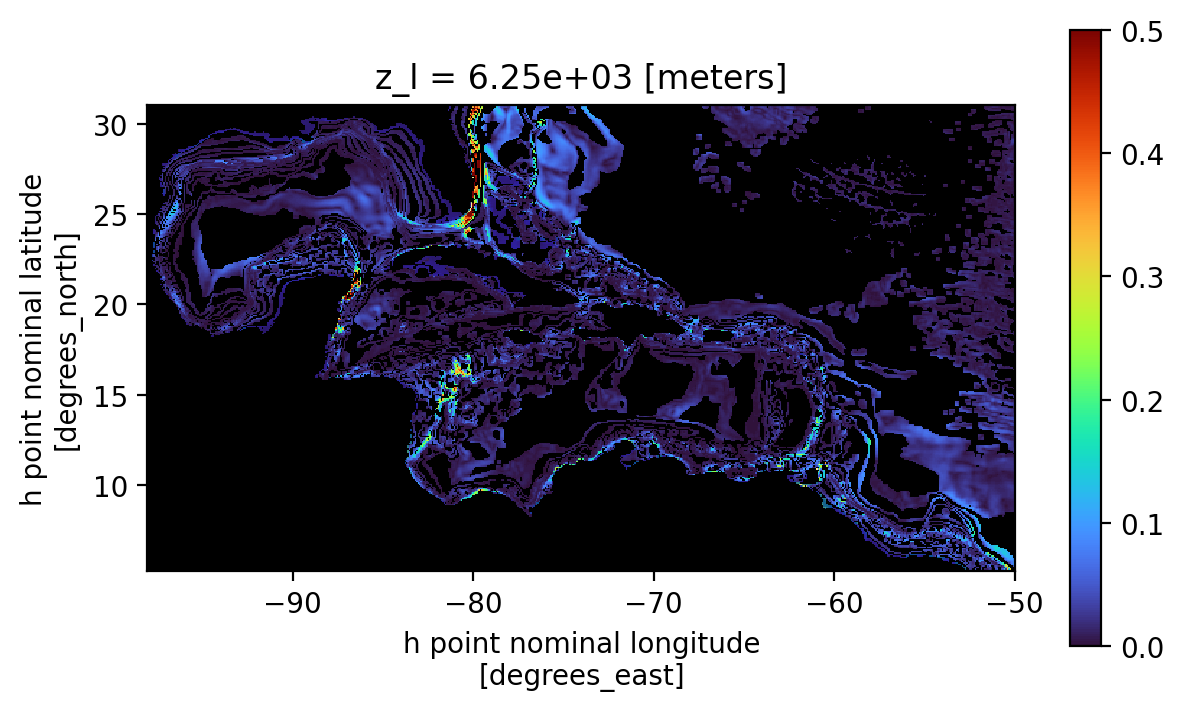

In [9]:
# nanmasked2 = plt.get_cmap('RdBu').copy()
# nanmasked2.set_bad('black')
fig, ax = plt.subplots(1, 1, figsize=(7,4),dpi=200)
umag.where(static.boundary_mask).isel(z_l=0).plot(cmap=nanmasked2,vmin=0,vmax=0.5,add_colorbar=False)
for i in range(1,17):
    umag.where(static.boundary_mask).isel(z_l=i*3).plot(cmap='turbo',vmin=0,vmax=0.5,add_colorbar=False)
# divo2.where(static.boundary_mask).isel(z_l=10).plot(cmap='cmo.haline',vmin=-4e-9,vmax=4e-9,add_colorbar=False)
# divo2.where(static.boundary_mask).isel(z_l=15).plot(cmap='cmo.haline',vmin=-4e-9,vmax=4e-9,add_colorbar=False)
# divo2.where(static.boundary_mask).isel(z_l=20).plot(cmap='cmo.haline',vmin=-4e-9,vmax=4e-9,add_colorbar=False)
umag.where(static.boundary_mask).isel(z_l=51).plot(cmap='turbo',vmin=0,vmax=0.5)
ax.set_aspect('equal')

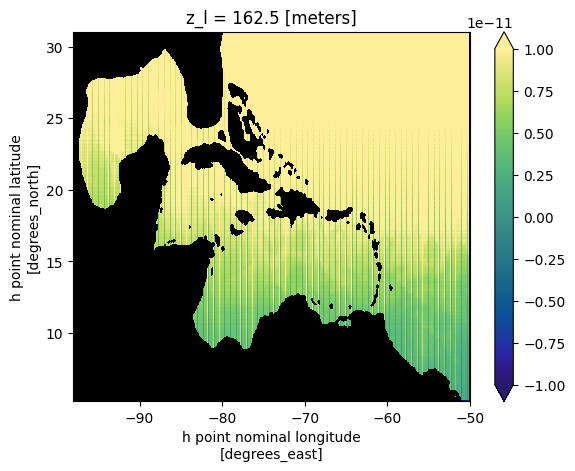

In [26]:
# divo22.isel(z_l=20).plot(cmap=nanmasked2,vmin=-4e-9,vmax=4e-9)
# (divo2-divo22).isel(z_l=20).plot(cmap=nanmasked2,vmin=-1e-11,vmax=1e-11)

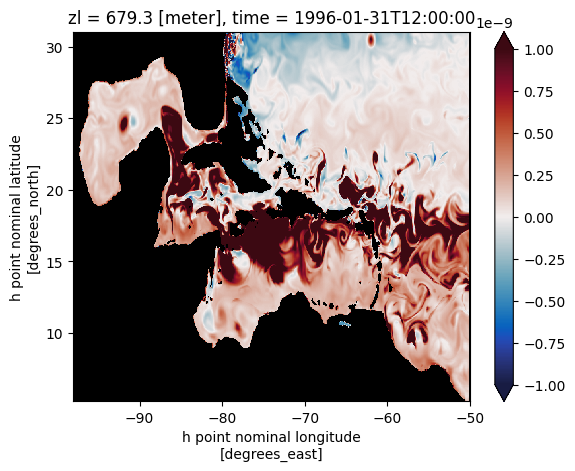

In [93]:
### calculating the buoyancy b = -grho'/rho0
# b = -9.8*(ds.Rho_cv-1035)/1035

# ds['b'] = xr.DataArray(data=b,
#                          coords={'time':ds['time'],'zl': ds['zl'],'yh': ds['yh'],'xh': ds['xh']},
#                          dims=('time','zl','yh','xh'))

# ds['kappa'] = xr.DataArray(data=ds.Kd_interface.isel(zi=slice(0,-1)),
#                          coords={'time':ds['time'],'zl': ds['zl'],'yh': ds['yh'],'xh': ds['xh']},
#                          dims=('time','zl','yh','xh'))

# gradkgradb = grid.interp((grid.derivative(ds.kappa.isel(time=30),'X'))*(grid.derivative(ds.b.isel(time=30),'X')),'X') + grid.interp((grid.derivative(ds.kappa.isel(time=30),'Y'))*(grid.derivative(ds.b.isel(time=30),'Y')),'Y') + ds.dbkz
# gradkgradb
# kd2b = ds.kappa.isel(time=30)*(grid.derivative(grid.derivative(ds.kappa.isel(time=30),'X'),'X') + grid.derivative(grid.derivative(ds.kappa.isel(time=30),'Y'),'Y') + ds.d2bz) 
# tbflux = kd2b + gradkgradb

# tbflux.where(static.wet_depth).isel(zl=46).plot(x='xh',y='yh',cmap=nanmasked2,vmin=-1e-9,vmax=1e-9)
# divdiffb = grid.interp(grid.derivative(ds.o2.mean('time'),'X'),'X') + grid.interp(grid.derivative(ds.o2.mean('time'),'Y'),'Y')

# ds.Kd_interface.where(static.wet_depth_zi).isel(time=0,zi=60).plot(x='xh',y='yh',cmap=nanmasked2,vmin=0,vmax=0.1)

In [60]:
# dbkz = (np.gradient(ds.kappa.isel(time=30),axis=0))*(np.gradient(ds.b.isel(time=30),axis=0))
d2bz = np.gradient(np.gradient(ds.b.isel(time=0),axis=0),axis=0)
ds['d2bz'] = xr.DataArray(data=d2bz,
                         coords={'zl': ds['zl'],'yh': ds['yh'],'xh': ds['xh']},
                         dims=('zl','yh','xh'))
# ds['dbkz'] = xr.DataArray(data=dbkz,
#                          coords={'zl': ds['zl'],'yh': ds['yh'],'xh': ds['xh']},
#                          dims=('zl','yh','xh'))
# del dbkz